## Fully connected dense models

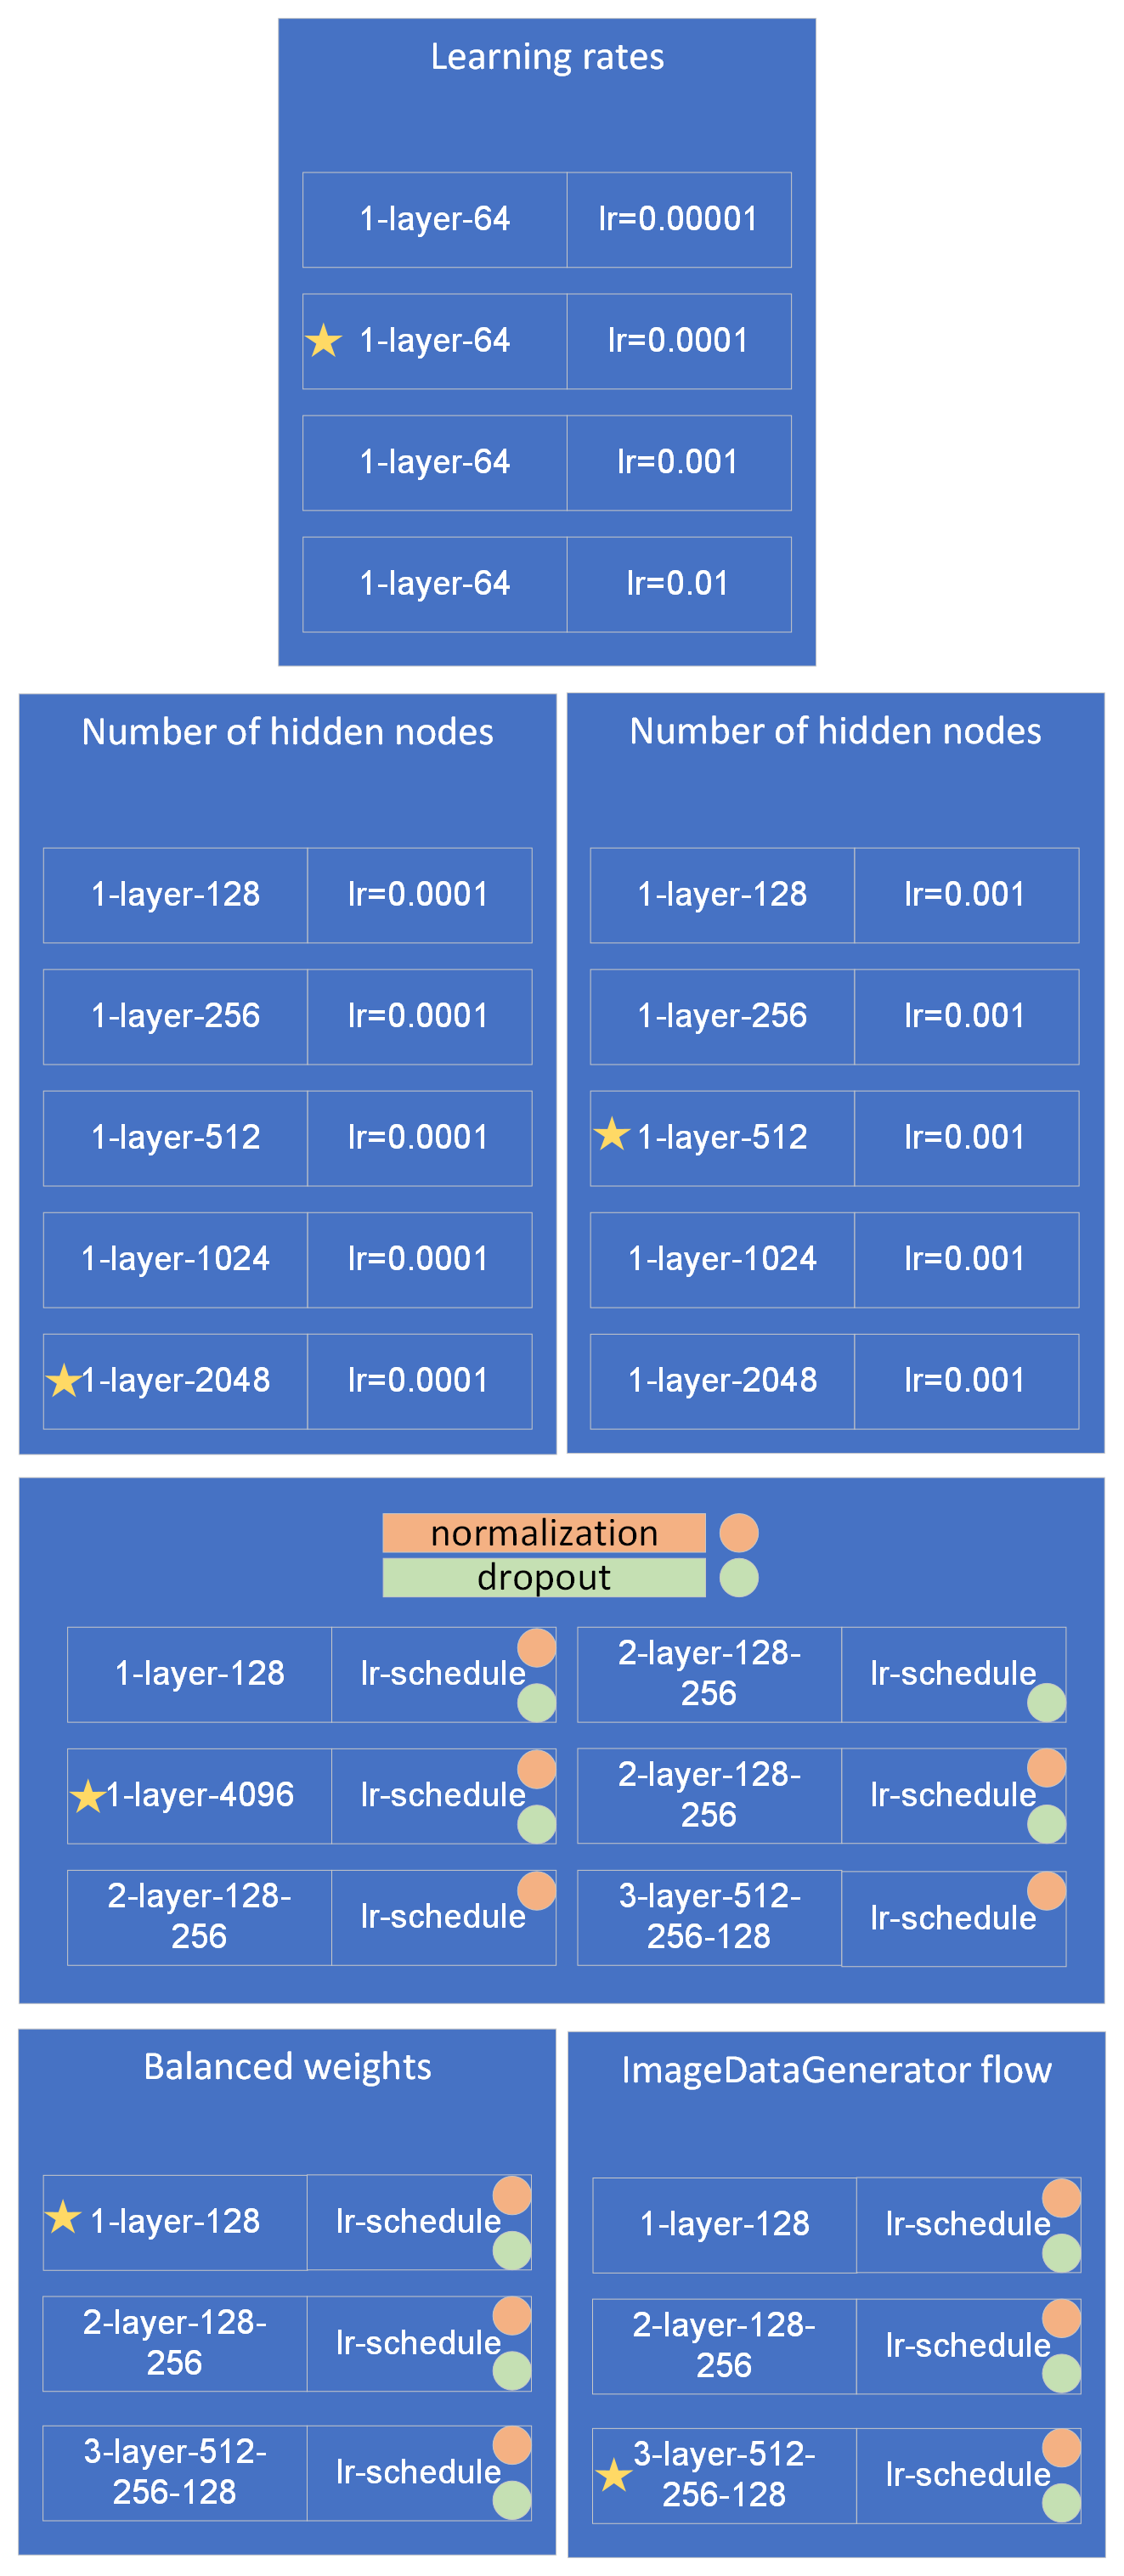

In [1]:
from IPython.display import Image
Image('densenets.png', width=500)

#### Import packages

In [2]:
import pandas
import numpy
import pickle
import sklearn
import sklearn.model_selection

# Graphs, visualizations
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from tensorflow import keras
from keras.optimizers import Adam, SGD

# For Image Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

batch_size = 1024

In [3]:
# Check for gpu support
# Troubleshooting: 
# Python Version = 3.7.9
# tensorflow Version = 2.3.0
# tf.keras Version = 2.4.0

# from platform import python_version
# print(python_version())
# print(tf.__version__)
# print(tf.keras.__version__)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Import Data From Pickle file

with open('y.pickle', 'rb') as f:
    y_data = pickle.load(f)
f.close()
y_data

with open('X.pickle', 'rb') as f:
    X_data = pickle.load(f)
f.close()
type(X_data)

list

In [5]:
def conf_matrix(model, x_test, y_test):
    
    y_pred = [1 * (x[0]>=0.5) for x in model.predict(x_test)]

    matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    df_cm = pandas.DataFrame(matrix, index = [i for i in ['No Cancer (actual)', 'Cancer (actual)']],
                      columns = [i for i in ['predict No Cancer', 'predict Cancer']])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    return plt

def acc_df(histories):
    columns = ['model size' ,'loss', 'accuracy', 'val_loss', 'val_accuracy']
    df = pandas.DataFrame(columns = columns)
    for history in histories:
    
    # get the epoch with the highest validation accuracy for each history element
        i = 0
        index = 0
        comp = 0
        for val_acc in history.history['val_accuracy']:
            if val_acc > comp:
                comp = val_acc
                i = index
            index += 1

        df_temp = pandas.DataFrame([[history.model.name,
                                  history.history['loss'][i],
                                  history.history['accuracy'][i],
                                  history.history['val_loss'][i],
                                  history.history['val_accuracy'][i]]], 
                        columns = columns)
        df = df.append(df_temp)

    df = df.set_index('model size')

    df = df.style.format({
        'loss': '{:,.2f}'.format,
        'accuracy': '{:,.2%}'.format,
        'val_loss': '{:,.2f}'.format,
        'val_accuracy': '{:,.2%}'.format,
    })

    return df

def plot_accuracies(histories, colors, lower_ylim=.7, upper_ylim=.9, alpha=.6, **kwargs):
    
    i = 0
    colors=colors
    
    for history in histories:
        plt.plot(history.history['accuracy'], alpha=alpha, color=colors[i])
        i += 1
    plt.xlabel('epoch')
    plt.ylabel('train accuracy')
    plt.ylim([lower_ylim,upper_ylim])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    i = 0
    for history in histories:
        plt.plot(history.history['val_accuracy'], alpha=alpha, color=colors[i])
        i += 1
    plt.xlabel('epoch')
    plt.ylabel('test accuracy')
    plt.ylim([lower_ylim,upper_ylim])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    
def prec_rec_df(models):
    columns = ['model' ,'precision (cancer positive)', 'recall (cancer positive)']
    df = pandas.DataFrame(columns = columns)
    for model in models:
        matrix = sklearn.metrics.confusion_matrix(y_test, [1 * (x[0]>=0.5) for x in model.predict(x_test)])
        precision = matrix[1][1]/(matrix[1][1]+matrix[0][1])
        recall = matrix[1][1]/(matrix[1][1]+matrix[1][0])


        df = df.append(pandas.DataFrame([[model.name,
                                      precision,
                                      recall]], 
                            columns = columns))
    df = df.set_index('model')

    df = df.style.format({
        'precision (cancer positive)': '{:,.2%}'.format,
        'recall (cancer positive)': '{:,.2%}'.format})

    return df

### Callbacks ###

#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)

#Learning Rate Annealer
lrr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.1,
                       patience=15,
                       min_lr=1e-4,
                       verbose=2)


In [6]:
# Train-validation-test split
# 60% Train, 20% Test, 20% Validation 

# train test split for validation after training x_test is never touched or looked at during training
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(numpy.asarray(X_data),
                                                                       numpy.asarray(y_data),
                                                                       test_size=.2,
                                                                       random_state=42)

# train test split for validation during training
x_train,x_val,y_train,y_val=sklearn.model_selection.train_test_split(x_train,
                                                                     y_train,
                                                                     test_size=.25,
                                                                     random_state=42)

#Dimension of the kaggle dataset & percentage of negative patches
print(x_train.shape,y_train.shape, 1-sum(y_train)/y_train.shape[0])
print(x_test.shape,y_test.shape, 1-sum(y_test)/y_test.shape[0])
print(x_val.shape,y_val.shape, 1-sum(y_val)/y_val.shape[0])

input_shape=x_train.shape[1:]
input_shape

(166514, 50, 50, 3) (166514,) 0.7144444310988866
(55505, 50, 50, 3) (55505,) 0.7182415998558689
(55505, 50, 50, 3) (55505,) 0.7189802720475633


(50, 50, 3)

In [7]:
# lower the number of epochs
epochs = 150

total = numpy.asarray(y_data).shape[0]
pos = sum(numpy.asarray(y_data))
neg = total - pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)

weight_for_0 = (1 / neg) * total
weight_for_1 = (1 / pos) * total

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


del X_data
del y_data

Weight for class 0: 1.40
Weight for class 1: 3.52


### Learnings
* The data of positive and negative samples is unbalanced, where patients have more negative patches than positive ones
* This could lead to an imbalanced result where we classify more patches as negative, which would be a severe mistake in cancer detection. A confusion matrix should be sufficient so verify this concern, when the model is trained
* The baseline for analysing the accuracy of our models is around 71.9%, where all patches would be classified as non malignant

### Learning Rates

As a first network we:
- Flatten the input from the images
- Use one hidden layer with 64 neurons and a sigmoid activation function
- Use one sigmoid activation function for the ouput layer

And experiment with different learning rates:

In [8]:
epochs = 1000
histories = []

name="1-layer-64-lr-0.00001"
model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model1.save_weights('model.h5')
model1.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.00001), metrics=["accuracy"])
histories.append(model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.0001"
model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model2.load_weights('model.h5')
model2.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.001"
model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model3.load_weights('model.h5')
model3.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])
histories.append(model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.01"
model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model4.load_weights('model.h5')
model4.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])
histories.append(model4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))
hist0 = histories

Epoch 1/1000
163/163 [==============================] - 1s 6ms/step - loss: 21.2261 - accuracy: 0.6316 - val_loss: 2.5154 - val_accuracy: 0.7318
Epoch 2/1000
163/163 [==============================] - 1s 5ms/step - loss: 4.4900 - accuracy: 0.6712 - val_loss: 1.9669 - val_accuracy: 0.6934
Epoch 3/1000
163/163 [==============================] - 1s 5ms/step - loss: 2.6121 - accuracy: 0.6989 - val_loss: 1.5625 - val_accuracy: 0.7476
Epoch 4/1000
163/163 [==============================] - 1s 5ms/step - loss: 1.9017 - accuracy: 0.7162 - val_loss: 1.8290 - val_accuracy: 0.7540
Epoch 5/1000
163/163 [==============================] - 1s 5ms/step - loss: 1.5038 - accuracy: 0.7261 - val_loss: 1.2389 - val_accuracy: 0.7563
Epoch 6/1000
163/163 [==============================] - 1s 5ms/step - loss: 1.1771 - accuracy: 0.7371 - val_loss: 1.0542 - val_accuracy: 0.7259
Epoch 7/1000
163/163 [==============================] - 1s 5ms/step - loss: 1.0074 - accuracy: 0.7345 - val_loss: 0.9971 - val_accuracy

163/163 [==============================] - 1s 5ms/step - loss: 0.4750 - accuracy: 0.7776 - val_loss: 0.4739 - val_accuracy: 0.7786
Epoch 58/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4747 - accuracy: 0.7777 - val_loss: 0.4734 - val_accuracy: 0.7806
Epoch 59/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4742 - accuracy: 0.7780 - val_loss: 0.4741 - val_accuracy: 0.7819
Epoch 60/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4738 - accuracy: 0.7783 - val_loss: 0.4727 - val_accuracy: 0.7806
Epoch 61/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4735 - accuracy: 0.7783 - val_loss: 0.4723 - val_accuracy: 0.7807
Epoch 62/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4733 - accuracy: 0.7786 - val_loss: 0.4724 - val_accuracy: 0.7824
Epoch 63/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4726 - accuracy: 0.7793 - val_loss: 0.4720 - val_accuracy: 0.7826

163/163 [==============================] - 1s 5ms/step - loss: 0.4599 - accuracy: 0.7872 - val_loss: 0.4597 - val_accuracy: 0.7899
Epoch 114/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4597 - accuracy: 0.7875 - val_loss: 0.4598 - val_accuracy: 0.7870
Epoch 115/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4594 - accuracy: 0.7873 - val_loss: 0.4591 - val_accuracy: 0.7884
Epoch 116/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4593 - accuracy: 0.7879 - val_loss: 0.4594 - val_accuracy: 0.7872
Epoch 117/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4591 - accuracy: 0.7876 - val_loss: 0.4590 - val_accuracy: 0.7879
Epoch 118/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4588 - accuracy: 0.7879 - val_loss: 0.4584 - val_accuracy: 0.7897
Epoch 119/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4586 - accuracy: 0.7883 - val_loss: 0.4585 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4506 - accuracy: 0.7932 - val_loss: 0.4510 - val_accuracy: 0.7937
Epoch 170/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4503 - accuracy: 0.7930 - val_loss: 0.4506 - val_accuracy: 0.7946
Epoch 171/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4502 - accuracy: 0.7933 - val_loss: 0.4505 - val_accuracy: 0.7942
Epoch 172/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4501 - accuracy: 0.7932 - val_loss: 0.4503 - val_accuracy: 0.7946
Epoch 173/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4498 - accuracy: 0.7940 - val_loss: 0.4515 - val_accuracy: 0.7926
Epoch 174/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4498 - accuracy: 0.7939 - val_loss: 0.4502 - val_accuracy: 0.7944
Epoch 175/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4496 - accuracy: 0.7941 - val_loss: 0.4500 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4442 - accuracy: 0.7977 - val_loss: 0.4450 - val_accuracy: 0.7983
Epoch 225/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4441 - accuracy: 0.7977 - val_loss: 0.4450 - val_accuracy: 0.7984
Epoch 226/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4440 - accuracy: 0.7983 - val_loss: 0.4447 - val_accuracy: 0.7983
Epoch 227/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4440 - accuracy: 0.7980 - val_loss: 0.4446 - val_accuracy: 0.7979
Epoch 228/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4438 - accuracy: 0.7981 - val_loss: 0.4448 - val_accuracy: 0.7986
Epoch 229/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4437 - accuracy: 0.7978 - val_loss: 0.4444 - val_accuracy: 0.7981
Epoch 230/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4435 - accuracy: 0.7981 - val_loss: 0.4450 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4392 - accuracy: 0.8013 - val_loss: 0.4403 - val_accuracy: 0.8019
Epoch 280/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4392 - accuracy: 0.8014 - val_loss: 0.4401 - val_accuracy: 0.8017
Epoch 281/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4391 - accuracy: 0.8011 - val_loss: 0.4402 - val_accuracy: 0.8020
Epoch 282/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4390 - accuracy: 0.8013 - val_loss: 0.4406 - val_accuracy: 0.8025
Epoch 283/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4390 - accuracy: 0.8013 - val_loss: 0.4400 - val_accuracy: 0.8019
Epoch 284/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4388 - accuracy: 0.8017 - val_loss: 0.4400 - val_accuracy: 0.8011
Epoch 285/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4387 - accuracy: 0.8018 - val_loss: 0.4398 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4353 - accuracy: 0.8041 - val_loss: 0.4364 - val_accuracy: 0.8044
Epoch 336/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4353 - accuracy: 0.8041 - val_loss: 0.4365 - val_accuracy: 0.8045
Epoch 337/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4351 - accuracy: 0.8043 - val_loss: 0.4362 - val_accuracy: 0.8042
Epoch 338/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4351 - accuracy: 0.8041 - val_loss: 0.4363 - val_accuracy: 0.8045
Epoch 339/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4350 - accuracy: 0.8045 - val_loss: 0.4361 - val_accuracy: 0.8043
Epoch 340/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4350 - accuracy: 0.8043 - val_loss: 0.4361 - val_accuracy: 0.8046
Epoch 341/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4349 - accuracy: 0.8044 - val_loss: 0.4361 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4320 - accuracy: 0.8063 - val_loss: 0.4334 - val_accuracy: 0.8067
Epoch 392/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4319 - accuracy: 0.8066 - val_loss: 0.4335 - val_accuracy: 0.8067
Epoch 393/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4319 - accuracy: 0.8066 - val_loss: 0.4331 - val_accuracy: 0.8065
Epoch 394/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4318 - accuracy: 0.8070 - val_loss: 0.4331 - val_accuracy: 0.8063
Epoch 395/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4317 - accuracy: 0.8067 - val_loss: 0.4331 - val_accuracy: 0.8066
Epoch 396/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4317 - accuracy: 0.8068 - val_loss: 0.4330 - val_accuracy: 0.8064
Epoch 397/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4316 - accuracy: 0.8066 - val_loss: 0.4330 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4291 - accuracy: 0.8084 - val_loss: 0.4311 - val_accuracy: 0.8085
Epoch 448/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4290 - accuracy: 0.8083 - val_loss: 0.4305 - val_accuracy: 0.8080
Epoch 449/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4290 - accuracy: 0.8085 - val_loss: 0.4307 - val_accuracy: 0.8082
Epoch 450/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4290 - accuracy: 0.8083 - val_loss: 0.4304 - val_accuracy: 0.8086
Epoch 451/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4289 - accuracy: 0.8083 - val_loss: 0.4303 - val_accuracy: 0.8085
Epoch 452/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4288 - accuracy: 0.8083 - val_loss: 0.4305 - val_accuracy: 0.8083
Epoch 453/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4287 - accuracy: 0.8085 - val_loss: 0.4303 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4266 - accuracy: 0.8098 - val_loss: 0.4283 - val_accuracy: 0.8094
Epoch 504/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4266 - accuracy: 0.8099 - val_loss: 0.4283 - val_accuracy: 0.8101
Epoch 505/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4265 - accuracy: 0.8098 - val_loss: 0.4282 - val_accuracy: 0.8097
Epoch 506/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4265 - accuracy: 0.8100 - val_loss: 0.4282 - val_accuracy: 0.8095
Epoch 507/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4266 - accuracy: 0.8098 - val_loss: 0.4287 - val_accuracy: 0.8091
Epoch 508/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4264 - accuracy: 0.8100 - val_loss: 0.4291 - val_accuracy: 0.8097
Epoch 509/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4264 - accuracy: 0.8102 - val_loss: 0.4287 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4247 - accuracy: 0.8110 - val_loss: 0.4264 - val_accuracy: 0.8110
Epoch 560/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4246 - accuracy: 0.8110 - val_loss: 0.4264 - val_accuracy: 0.8111
Epoch 561/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4246 - accuracy: 0.8110 - val_loss: 0.4264 - val_accuracy: 0.8109
Epoch 562/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4245 - accuracy: 0.8108 - val_loss: 0.4267 - val_accuracy: 0.8110
Epoch 563/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4245 - accuracy: 0.8111 - val_loss: 0.4263 - val_accuracy: 0.8110
Epoch 564/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4245 - accuracy: 0.8110 - val_loss: 0.4265 - val_accuracy: 0.8106
Epoch 565/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4244 - accuracy: 0.8111 - val_loss: 0.4262 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4230 - accuracy: 0.8118 - val_loss: 0.4250 - val_accuracy: 0.8114
Epoch 616/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4229 - accuracy: 0.8118 - val_loss: 0.4250 - val_accuracy: 0.8121
Epoch 617/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4229 - accuracy: 0.8117 - val_loss: 0.4248 - val_accuracy: 0.8119
Epoch 618/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4229 - accuracy: 0.8119 - val_loss: 0.4250 - val_accuracy: 0.8123
Epoch 619/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4229 - accuracy: 0.8119 - val_loss: 0.4252 - val_accuracy: 0.8120
Epoch 620/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4229 - accuracy: 0.8115 - val_loss: 0.4256 - val_accuracy: 0.8119
Epoch 621/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4228 - accuracy: 0.8117 - val_loss: 0.4248 - val_accuracy: 

Epoch 671/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4215 - accuracy: 0.8123 - val_loss: 0.4236 - val_accuracy: 0.8127
Epoch 672/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4215 - accuracy: 0.8123 - val_loss: 0.4238 - val_accuracy: 0.8126
Epoch 673/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4215 - accuracy: 0.8125 - val_loss: 0.4236 - val_accuracy: 0.8132
Epoch 674/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4215 - accuracy: 0.8123 - val_loss: 0.4235 - val_accuracy: 0.8129
Epoch 675/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4214 - accuracy: 0.8124 - val_loss: 0.4237 - val_accuracy: 0.8129
Epoch 676/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4214 - accuracy: 0.8123 - val_loss: 0.4235 - val_accuracy: 0.8131
Epoch 677/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4214 - accuracy: 0.8126 - val_loss: 0.4235 -

163/163 [==============================] - 1s 5ms/step - loss: 0.4203 - accuracy: 0.8131 - val_loss: 0.4227 - val_accuracy: 0.8130
Epoch 728/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4202 - accuracy: 0.8130 - val_loss: 0.4225 - val_accuracy: 0.8133
Epoch 729/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4202 - accuracy: 0.8131 - val_loss: 0.4233 - val_accuracy: 0.8127
Epoch 730/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4202 - accuracy: 0.8130 - val_loss: 0.4232 - val_accuracy: 0.8130
Epoch 731/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4202 - accuracy: 0.8129 - val_loss: 0.4228 - val_accuracy: 0.8123
Epoch 732/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4202 - accuracy: 0.8128 - val_loss: 0.4233 - val_accuracy: 0.8120
Epoch 733/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4201 - accuracy: 0.8132 - val_loss: 0.4231 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4192 - accuracy: 0.8137 - val_loss: 0.4215 - val_accuracy: 0.8141
Epoch 784/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4192 - accuracy: 0.8136 - val_loss: 0.4224 - val_accuracy: 0.8124
Epoch 785/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4192 - accuracy: 0.8135 - val_loss: 0.4221 - val_accuracy: 0.8135
Epoch 786/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4192 - accuracy: 0.8133 - val_loss: 0.4215 - val_accuracy: 0.8139
Epoch 787/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4191 - accuracy: 0.8134 - val_loss: 0.4214 - val_accuracy: 0.8136
Epoch 788/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4191 - accuracy: 0.8137 - val_loss: 0.4214 - val_accuracy: 0.8139
Epoch 789/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4191 - accuracy: 0.8136 - val_loss: 0.4214 - val_accuracy: 

Epoch 839/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8141 - val_loss: 0.4207 - val_accuracy: 0.8138
Epoch 840/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8139 - val_loss: 0.4207 - val_accuracy: 0.8141
Epoch 841/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8140 - val_loss: 0.4211 - val_accuracy: 0.8135
Epoch 842/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8141 - val_loss: 0.4206 - val_accuracy: 0.8139
Epoch 843/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8141 - val_loss: 0.4205 - val_accuracy: 0.8139
Epoch 844/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4181 - accuracy: 0.8143 - val_loss: 0.4206 - val_accuracy: 0.8139
Epoch 845/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4181 - accuracy: 0.8141 - val_loss: 0.4207 -

Epoch 895/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8146 - val_loss: 0.4198 - val_accuracy: 0.8140
Epoch 896/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8144 - val_loss: 0.4201 - val_accuracy: 0.8142
Epoch 897/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8145 - val_loss: 0.4198 - val_accuracy: 0.8142
Epoch 898/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8146 - val_loss: 0.4198 - val_accuracy: 0.8139
Epoch 899/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8144 - val_loss: 0.4201 - val_accuracy: 0.8143
Epoch 900/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8143 - val_loss: 0.4198 - val_accuracy: 0.8142
Epoch 901/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8145 - val_loss: 0.4198 -

163/163 [==============================] - 1s 5ms/step - loss: 0.4164 - accuracy: 0.8151 - val_loss: 0.4192 - val_accuracy: 0.8144
Epoch 952/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4164 - accuracy: 0.8150 - val_loss: 0.4190 - val_accuracy: 0.8145
Epoch 953/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4163 - accuracy: 0.8149 - val_loss: 0.4195 - val_accuracy: 0.8146
Epoch 954/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4164 - accuracy: 0.8150 - val_loss: 0.4189 - val_accuracy: 0.8144
Epoch 955/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4163 - accuracy: 0.8148 - val_loss: 0.4199 - val_accuracy: 0.8137
Epoch 956/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4163 - accuracy: 0.8152 - val_loss: 0.4189 - val_accuracy: 0.8148
Epoch 957/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4163 - accuracy: 0.8151 - val_loss: 0.4189 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4899 - accuracy: 0.7641 - val_loss: 0.4843 - val_accuracy: 0.7662
Epoch 8/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4839 - accuracy: 0.7684 - val_loss: 0.4786 - val_accuracy: 0.7710: 0s - loss: 0.4847 - accu
Epoch 9/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4781 - accuracy: 0.7730 - val_loss: 0.4739 - val_accuracy: 0.7780
Epoch 10/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4731 - accuracy: 0.7765 - val_loss: 0.4687 - val_accuracy: 0.7783
Epoch 11/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4692 - accuracy: 0.7793 - val_loss: 0.4648 - val_accuracy: 0.7819
Epoch 12/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4659 - accuracy: 0.7814 - val_loss: 0.4620 - val_accuracy: 0.7837
Epoch 13/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4629 - accuracy: 0.7839 - val_loss: 0.461

Epoch 63/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4235 - accuracy: 0.8095 - val_loss: 0.4239 - val_accuracy: 0.8091
Epoch 64/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4233 - accuracy: 0.8097 - val_loss: 0.4241 - val_accuracy: 0.8086
Epoch 65/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4230 - accuracy: 0.8096 - val_loss: 0.4240 - val_accuracy: 0.8086
Epoch 66/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4229 - accuracy: 0.8097 - val_loss: 0.4252 - val_accuracy: 0.8080
Epoch 67/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4224 - accuracy: 0.8103 - val_loss: 0.4242 - val_accuracy: 0.8085
Epoch 68/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4223 - accuracy: 0.8103 - val_loss: 0.4246 - val_accuracy: 0.8080
Epoch 69/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4223 - accuracy: 0.8102 - val_loss: 0.4227 - val_ac

163/163 [==============================] - 1s 5ms/step - loss: 0.4145 - accuracy: 0.8149 - val_loss: 0.4164 - val_accuracy: 0.8133
Epoch 120/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4143 - accuracy: 0.8152 - val_loss: 0.4176 - val_accuracy: 0.8127
Epoch 121/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4142 - accuracy: 0.8152 - val_loss: 0.4159 - val_accuracy: 0.8140
Epoch 122/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4142 - accuracy: 0.8151 - val_loss: 0.4159 - val_accuracy: 0.8139
Epoch 123/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4138 - accuracy: 0.8153 - val_loss: 0.4158 - val_accuracy: 0.8144
Epoch 124/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4140 - accuracy: 0.8156 - val_loss: 0.4156 - val_accuracy: 0.8145
Epoch 125/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4138 - accuracy: 0.8153 - val_loss: 0.4159 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4101 - accuracy: 0.8174 - val_loss: 0.4134 - val_accuracy: 0.8163
Epoch 176/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4103 - accuracy: 0.8172 - val_loss: 0.4152 - val_accuracy: 0.8148
Epoch 177/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4100 - accuracy: 0.8173 - val_loss: 0.4176 - val_accuracy: 0.8137
Epoch 178/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4100 - accuracy: 0.8175 - val_loss: 0.4147 - val_accuracy: 0.8162
Epoch 179/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4097 - accuracy: 0.8176 - val_loss: 0.4151 - val_accuracy: 0.8152
Epoch 180/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4097 - accuracy: 0.8174 - val_loss: 0.4127 - val_accuracy: 0.8161
Epoch 181/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4099 - accuracy: 0.8173 - val_loss: 0.4140 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4071 - accuracy: 0.8191 - val_loss: 0.4101 - val_accuracy: 0.8171
Epoch 232/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4071 - accuracy: 0.8190 - val_loss: 0.4102 - val_accuracy: 0.8174
Epoch 233/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4071 - accuracy: 0.8190 - val_loss: 0.4187 - val_accuracy: 0.8136
Epoch 234/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4069 - accuracy: 0.8191 - val_loss: 0.4121 - val_accuracy: 0.8169
Epoch 235/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4072 - accuracy: 0.8190 - val_loss: 0.4110 - val_accuracy: 0.8179
Epoch 236/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4073 - accuracy: 0.8190 - val_loss: 0.4100 - val_accuracy: 0.8174
Epoch 237/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4072 - accuracy: 0.8189 - val_loss: 0.4100 - val_accuracy: 

Epoch 287/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4048 - accuracy: 0.8203 - val_loss: 0.4088 - val_accuracy: 0.8187
Epoch 288/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4049 - accuracy: 0.8199 - val_loss: 0.4083 - val_accuracy: 0.8183
Epoch 289/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4048 - accuracy: 0.8203 - val_loss: 0.4087 - val_accuracy: 0.8186
Epoch 290/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4047 - accuracy: 0.8203 - val_loss: 0.4084 - val_accuracy: 0.8186
Epoch 291/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4047 - accuracy: 0.8205 - val_loss: 0.4098 - val_accuracy: 0.8177
Epoch 292/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4046 - accuracy: 0.8204 - val_loss: 0.4084 - val_accuracy: 0.8186
Epoch 293/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4046 - accuracy: 0.8204 - val_loss: 0.4112 -

163/163 [==============================] - 1s 5ms/step - loss: 0.4031 - accuracy: 0.8213 - val_loss: 0.4078 - val_accuracy: 0.8199
Epoch 344/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4030 - accuracy: 0.8214 - val_loss: 0.4073 - val_accuracy: 0.8196
Epoch 345/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4029 - accuracy: 0.8213 - val_loss: 0.4077 - val_accuracy: 0.8193
Epoch 346/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4029 - accuracy: 0.8211 - val_loss: 0.4085 - val_accuracy: 0.8187
Epoch 347/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4029 - accuracy: 0.8214 - val_loss: 0.4118 - val_accuracy: 0.8169
Epoch 348/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4030 - accuracy: 0.8213 - val_loss: 0.4072 - val_accuracy: 0.8199
Epoch 349/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4029 - accuracy: 0.8215 - val_loss: 0.4120 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.4015 - accuracy: 0.8220 - val_loss: 0.4074 - val_accuracy: 0.8208
Epoch 400/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4013 - accuracy: 0.8219 - val_loss: 0.4060 - val_accuracy: 0.8202
Epoch 401/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4011 - accuracy: 0.8223 - val_loss: 0.4066 - val_accuracy: 0.8209
Epoch 402/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4012 - accuracy: 0.8222 - val_loss: 0.4063 - val_accuracy: 0.8201
Epoch 403/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4012 - accuracy: 0.8219 - val_loss: 0.4067 - val_accuracy: 0.8204
Epoch 404/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4011 - accuracy: 0.8222 - val_loss: 0.4116 - val_accuracy: 0.8171
Epoch 405/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4015 - accuracy: 0.8220 - val_loss: 0.4060 - val_accuracy: 

Epoch 455/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4000 - accuracy: 0.8227 - val_loss: 0.4059 - val_accuracy: 0.8207
Epoch 456/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3999 - accuracy: 0.8229 - val_loss: 0.4062 - val_accuracy: 0.8215
Epoch 457/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3999 - accuracy: 0.8230 - val_loss: 0.4059 - val_accuracy: 0.8206
Epoch 458/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3996 - accuracy: 0.8232 - val_loss: 0.4052 - val_accuracy: 0.8209
Epoch 459/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.4000 - accuracy: 0.8228 - val_loss: 0.4059 - val_accuracy: 0.8217
Epoch 460/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3999 - accuracy: 0.8231 - val_loss: 0.4072 - val_accuracy: 0.8191
Epoch 461/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3996 - accuracy: 0.8230 - val_loss: 0.4060 -

Epoch 511/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3990 - accuracy: 0.8237 - val_loss: 0.4064 - val_accuracy: 0.8215
Epoch 512/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3990 - accuracy: 0.8235 - val_loss: 0.4045 - val_accuracy: 0.8217
Epoch 513/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3985 - accuracy: 0.8239 - val_loss: 0.4044 - val_accuracy: 0.8218
Epoch 514/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3987 - accuracy: 0.8239 - val_loss: 0.4060 - val_accuracy: 0.8216
Epoch 515/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3988 - accuracy: 0.8237 - val_loss: 0.4048 - val_accuracy: 0.8216
Epoch 516/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3987 - accuracy: 0.8239 - val_loss: 0.4056 - val_accuracy: 0.8216
Epoch 517/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3984 - accuracy: 0.8241 - val_loss: 0.4046 -

163/163 [==============================] - 1s 5ms/step - loss: 0.3976 - accuracy: 0.8245 - val_loss: 0.4040 - val_accuracy: 0.8219
Epoch 568/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3976 - accuracy: 0.8245 - val_loss: 0.4069 - val_accuracy: 0.8214
Epoch 569/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3976 - accuracy: 0.8245 - val_loss: 0.4048 - val_accuracy: 0.8215
Epoch 570/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3975 - accuracy: 0.8249 - val_loss: 0.4048 - val_accuracy: 0.8218
Epoch 571/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3975 - accuracy: 0.8246 - val_loss: 0.4055 - val_accuracy: 0.8210
Epoch 572/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3974 - accuracy: 0.8245 - val_loss: 0.4040 - val_accuracy: 0.8222
Epoch 573/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3979 - accuracy: 0.8243 - val_loss: 0.4083 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.3965 - accuracy: 0.8250 - val_loss: 0.4047 - val_accuracy: 0.8217
Epoch 624/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3966 - accuracy: 0.8254 - val_loss: 0.4055 - val_accuracy: 0.8223
Epoch 625/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3963 - accuracy: 0.8249 - val_loss: 0.4037 - val_accuracy: 0.8226
Epoch 626/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3966 - accuracy: 0.8252 - val_loss: 0.4036 - val_accuracy: 0.8228
Epoch 627/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3964 - accuracy: 0.8252 - val_loss: 0.4042 - val_accuracy: 0.8221
Epoch 628/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3964 - accuracy: 0.8249 - val_loss: 0.4035 - val_accuracy: 0.8229
Epoch 629/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3962 - accuracy: 0.8252 - val_loss: 0.4034 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.3957 - accuracy: 0.8256 - val_loss: 0.4029 - val_accuracy: 0.8228
Epoch 680/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3955 - accuracy: 0.8260 - val_loss: 0.4054 - val_accuracy: 0.8223
Epoch 681/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3956 - accuracy: 0.8254 - val_loss: 0.4029 - val_accuracy: 0.8235
Epoch 682/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3955 - accuracy: 0.8259 - val_loss: 0.4032 - val_accuracy: 0.8227
Epoch 683/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3956 - accuracy: 0.8258 - val_loss: 0.4051 - val_accuracy: 0.8205
Epoch 684/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3951 - accuracy: 0.8260 - val_loss: 0.4055 - val_accuracy: 0.8204
Epoch 685/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3954 - accuracy: 0.8260 - val_loss: 0.4034 - val_accuracy: 

Epoch 735/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3948 - accuracy: 0.8267 - val_loss: 0.4031 - val_accuracy: 0.8231
Epoch 736/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3947 - accuracy: 0.8264 - val_loss: 0.4048 - val_accuracy: 0.8224
Epoch 737/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3947 - accuracy: 0.8262 - val_loss: 0.4029 - val_accuracy: 0.8232
Epoch 738/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3947 - accuracy: 0.8261 - val_loss: 0.4105 - val_accuracy: 0.8181
Epoch 739/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3945 - accuracy: 0.8265 - val_loss: 0.4047 - val_accuracy: 0.8227
Epoch 740/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3946 - accuracy: 0.8263 - val_loss: 0.4031 - val_accuracy: 0.8232
Epoch 741/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3945 - accuracy: 0.8265 - val_loss: 0.4031 -

163/163 [==============================] - 1s 5ms/step - loss: 0.3936 - accuracy: 0.8268 - val_loss: 0.4023 - val_accuracy: 0.8237
Epoch 792/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3936 - accuracy: 0.8266 - val_loss: 0.4033 - val_accuracy: 0.8234oss: 0.3937 - accuracy: 0.82
Epoch 793/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3936 - accuracy: 0.8269 - val_loss: 0.4022 - val_accuracy: 0.8235
Epoch 794/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3939 - accuracy: 0.8270 - val_loss: 0.4067 - val_accuracy: 0.8202
Epoch 795/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3936 - accuracy: 0.8269 - val_loss: 0.4022 - val_accuracy: 0.8238
Epoch 796/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3937 - accuracy: 0.8265 - val_loss: 0.4023 - val_accuracy: 0.8237
Epoch 797/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3939 - accuracy: 0.8268 - val_l

163/163 [==============================] - 1s 5ms/step - loss: 0.3928 - accuracy: 0.8272 - val_loss: 0.4027 - val_accuracy: 0.8237
Epoch 847/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3928 - accuracy: 0.8273 - val_loss: 0.4035 - val_accuracy: 0.8219
Epoch 848/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3927 - accuracy: 0.8276 - val_loss: 0.4029 - val_accuracy: 0.8234
Epoch 849/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3929 - accuracy: 0.8272 - val_loss: 0.4038 - val_accuracy: 0.8231
Epoch 850/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3930 - accuracy: 0.8273 - val_loss: 0.4051 - val_accuracy: 0.8211
Epoch 851/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3929 - accuracy: 0.8274 - val_loss: 0.4024 - val_accuracy: 0.8227
Epoch 852/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3927 - accuracy: 0.8273 - val_loss: 0.4077 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.3920 - accuracy: 0.8274 - val_loss: 0.4031 - val_accuracy: 0.8232
Epoch 903/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3919 - accuracy: 0.8282 - val_loss: 0.4023 - val_accuracy: 0.8232
Epoch 904/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3922 - accuracy: 0.8274 - val_loss: 0.4038 - val_accuracy: 0.8233
Epoch 905/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3920 - accuracy: 0.8279 - val_loss: 0.4025 - val_accuracy: 0.8232
Epoch 906/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3922 - accuracy: 0.8275 - val_loss: 0.4022 - val_accuracy: 0.8231
Epoch 907/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3922 - accuracy: 0.8276 - val_loss: 0.4021 - val_accuracy: 0.8234
Epoch 908/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3918 - accuracy: 0.8278 - val_loss: 0.4018 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.3911 - accuracy: 0.8284 - val_loss: 0.4021 - val_accuracy: 0.8242
Epoch 959/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3913 - accuracy: 0.8281 - val_loss: 0.4019 - val_accuracy: 0.8236
Epoch 960/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3912 - accuracy: 0.8282 - val_loss: 0.4048 - val_accuracy: 0.8220
Epoch 961/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3914 - accuracy: 0.8284 - val_loss: 0.4026 - val_accuracy: 0.8233
Epoch 962/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3910 - accuracy: 0.8280 - val_loss: 0.4017 - val_accuracy: 0.8239
Epoch 963/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3914 - accuracy: 0.8284 - val_loss: 0.4017 - val_accuracy: 0.8236
Epoch 964/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.3912 - accuracy: 0.8280 - val_loss: 0.4040 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.6315 - accuracy: 0.7144 - val_loss: 0.6290 - val_accuracy: 0.7189
Epoch 15/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6290 - accuracy: 0.7144 - val_loss: 0.6265 - val_accuracy: 0.7189
Epoch 16/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6267 - accuracy: 0.7144 - val_loss: 0.6242 - val_accuracy: 0.7189
Epoch 17/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6247 - accuracy: 0.7144 - val_loss: 0.6222 - val_accuracy: 0.7189
Epoch 18/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6228 - accuracy: 0.7144 - val_loss: 0.6202 - val_accuracy: 0.7189
Epoch 19/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6210 - accuracy: 0.7144 - val_loss: 0.6184 - val_accuracy: 0.7189
Epoch 20/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.6194 - accuracy: 0.7144 - val_loss: 0.6167 - val_accuracy: 0.7189

163/163 [==============================] - 1s 5ms/step - loss: 0.5984 - accuracy: 0.7145 - val_loss: 0.5954 - val_accuracy: 0.7189
Epoch 71/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5984 - accuracy: 0.7145 - val_loss: 0.5954 - val_accuracy: 0.7189
Epoch 72/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5985 - accuracy: 0.7145 - val_loss: 0.5950 - val_accuracy: 0.7189
Epoch 73/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5984 - accuracy: 0.7145 - val_loss: 0.5950 - val_accuracy: 0.7189
Epoch 74/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5983 - accuracy: 0.7145 - val_loss: 0.5952 - val_accuracy: 0.7189
Epoch 75/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5983 - accuracy: 0.7145 - val_loss: 0.5957 - val_accuracy: 0.7189
Epoch 76/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5982 - accuracy: 0.7145 - val_loss: 0.5949 - val_accuracy: 0.7189

163/163 [==============================] - 1s 5ms/step - loss: 0.5975 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 127/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 128/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 129/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 130/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 131/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 132/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5977 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 183/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 184/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 185/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 186/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 187/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 188/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 239/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 240/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 241/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 242/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 243/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 244/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 295/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 296/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 297/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 298/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 299/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 300/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 351/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 352/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 353/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 354/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 355/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 356/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 

Epoch 406/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 407/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 408/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 409/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 410/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 411/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 412/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 463/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 464/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 465/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 466/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 467/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 468/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 

Epoch 518/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 519/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 520/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 521/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 522/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 523/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 524/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7189
Epoch 575/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7189
Epoch 576/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5941 - val_accuracy: 0.7189
Epoch 577/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5943 - val_accuracy: 0.7189
Epoch 578/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 579/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7189
Epoch 580/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5941 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 631/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 632/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 633/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 634/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5944 - val_accuracy: 0.7189
Epoch 635/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7145 - val_loss: 0.5941 - val_accuracy: 0.7189
Epoch 636/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 

Epoch 686/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5945 - val_accuracy: 0.7189
Epoch 687/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5979 - accuracy: 0.7145 - val_loss: 0.5937 - val_accuracy: 0.7189
Epoch 688/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5976 - accuracy: 0.7145 - val_loss: 0.5937 - val_accuracy: 0.7189
Epoch 689/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5944 - val_accuracy: 0.7189
Epoch 690/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5942 - val_accuracy: 0.7189
Epoch 691/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5976 - accuracy: 0.7145 - val_loss: 0.5945 - val_accuracy: 0.7189
Epoch 692/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5978 - accuracy: 0.7145 - val_loss: 0.5942 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5972 - accuracy: 0.7145 - val_loss: 0.5944 - val_accuracy: 0.7189
Epoch 743/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5971 - accuracy: 0.7145 - val_loss: 0.5940 - val_accuracy: 0.7189
Epoch 744/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5972 - accuracy: 0.7145 - val_loss: 0.5945 - val_accuracy: 0.7189
Epoch 745/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5976 - accuracy: 0.7145 - val_loss: 0.5939 - val_accuracy: 0.7189
Epoch 746/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5973 - accuracy: 0.7145 - val_loss: 0.5941 - val_accuracy: 0.7189
Epoch 747/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5973 - accuracy: 0.7145 - val_loss: 0.5941 - val_accuracy: 0.7189
Epoch 748/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5972 - accuracy: 0.7145 - val_loss: 0.5941 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 799/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 800/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 801/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 802/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 803/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 804/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5980 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 

Epoch 854/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 855/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 856/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 857/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 858/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189 - loss: 0.5981 - accuracy
Epoch 859/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 860/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0

Epoch 910/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 911/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 912/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 913/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 914/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 915/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 916/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 967/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 968/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 969/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 970/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 971/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 0.7189
Epoch 972/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7145 - val_loss: 0.5946 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 23/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 24/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 25/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 26/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 27/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 28/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 79/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 80/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 81/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 82/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 83/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 84/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 135/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 136/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 137/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 138/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 139/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 140/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 191/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 192/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 193/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 194/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 195/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 196/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 247/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 248/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 249/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190 - loss: 0.5978 - accuracy:  - ETA: 0s - loss: 0.5977 - accuracy: 0.
Epoch 250/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 251/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 252/1000
163/163 [==============================] - 1s 5ms/step -

Epoch 302/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 303/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 304/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 305/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 306/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 307/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 308/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 359/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 360/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 361/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 362/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 363/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 364/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 415/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 416/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 417/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 418/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 419/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 420/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

Epoch 470/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 471/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 472/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 473/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 474/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 475/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 476/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 -

Epoch 526/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 527/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 528/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 529/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 530/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 531/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 532/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 583/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 584/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 585/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 586/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 587/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 588/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 639/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 640/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 641/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 642/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 643/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 644/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 695/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 696/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 697/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 698/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 699/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 700/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 751/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 752/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 753/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 754/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 755/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 756/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 807/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 808/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 809/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 810/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 811/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 812/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 863/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 864/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 865/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 866/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 867/1000
163/163 [==============================] - ETA: 0s - loss: 0.5979 - accuracy: 0.71 - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 868/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 

Epoch 918/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 919/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 920/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 921/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 922/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 923/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 924/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 -

163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 975/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 976/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 977/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 978/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 979/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 980/1000
163/163 [==============================] - 1s 5ms/step - loss: 0.5981 - accuracy: 0.7144 - val_loss: 0.5940 - val_accuracy: 

In [9]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-64-lr-0.00001,0.42,81.54%,0.42,81.50%
1-layer-64-lr-0.0001,0.39,82.82%,0.40,82.48%
1-layer-64-lr-0.001,0.60,71.45%,0.60,71.89%
1-layer-64-lr-0.01,"12,869.02",71.17%,0.64,71.90%


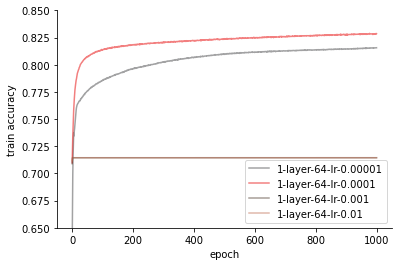

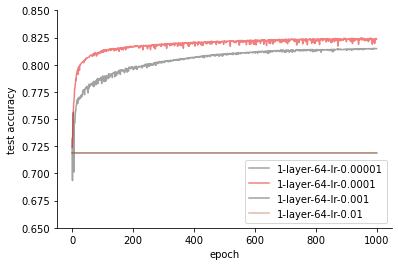

In [10]:
plot_accuracies(hist0, colors=['#464749','#e60000' ,'#4d3c2f', '#c07156', '#806b59', '#b9b2a3'] , alpha=.5, lower_ylim=.65, upper_ylim=.85)

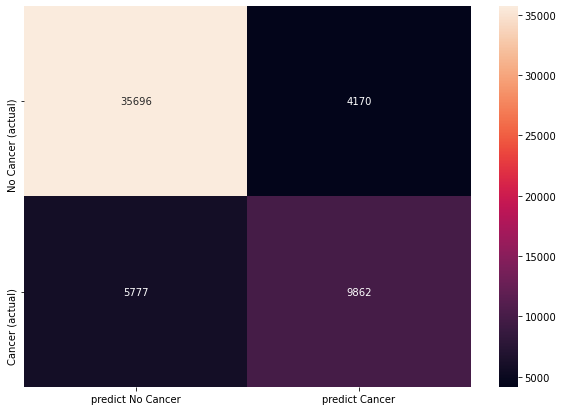

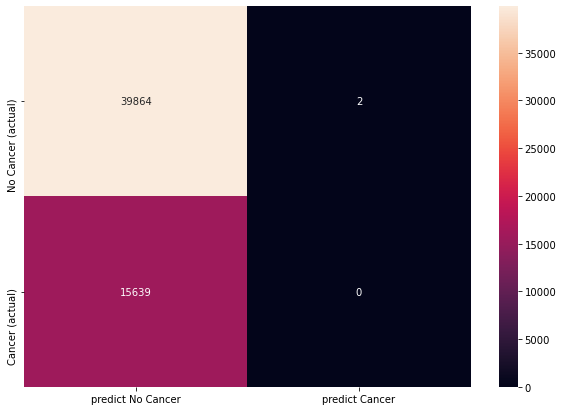

In [11]:
# plot confuction matrix
plt=conf_matrix(model2, x_test, y_test)
plt.show()

# plot confuction matrix
plt=conf_matrix(model3, x_test, y_test)
plt.show()

## Learnings
* Only two learning rates are able to improve above the base line
* Learning rates higher than 0.001 are not able to improve
    * Reason for this could be the used stochastic gradient descent optimizer, for further models we will switch to adam optimizer, which is bases on stochastic gradient descent

## Hidden nodes and adam optimizer

Experiment with models with one hidden layer but more hidden nodes.

All models are tested with the best learning rate from the previous experiment (0.0001) but also with a higher learning rate to check if bigger models manage to learn with a higher learning (0.001) rate.

* 128 Nodes
* 256 Nodes
* 512 Nodes
* 1024 Nodes
* 2048 Nodes
* 4096 Nodes

In [12]:
# lower the number of epochs
epochs = 150

histories = []

name="1-layer-128"
print(name)
model01 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model01.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model01.fit(x_train, y_train, batch_size=batch_size,
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))


name="1-layer-256"
print(name)
model02 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model02.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model02.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-512"
print(name)
model03 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model03.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model03.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-1024"
print(name)
model04 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model04.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model04.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-2048"
print(name)
model05 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model05.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model05.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-4096"
print(name)
model06 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model06.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model06.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))
hist1 = histories

1-layer-128
Epoch 1/150
163/163 - 1s - loss: 24.4848 - accuracy: 0.6658 - val_loss: 5.8448 - val_accuracy: 0.7310
Epoch 2/150
163/163 - 1s - loss: 5.7097 - accuracy: 0.7144 - val_loss: 4.7949 - val_accuracy: 0.7233
Epoch 3/150
163/163 - 1s - loss: 8.7276 - accuracy: 0.7040 - val_loss: 7.7615 - val_accuracy: 0.5959
Epoch 4/150
163/163 - 1s - loss: 5.4421 - accuracy: 0.7345 - val_loss: 4.3491 - val_accuracy: 0.7619
Epoch 5/150
163/163 - 1s - loss: 8.1274 - accuracy: 0.7050 - val_loss: 5.6245 - val_accuracy: 0.7816
Epoch 6/150
163/163 - 1s - loss: 5.3799 - accuracy: 0.7396 - val_loss: 9.4180 - val_accuracy: 0.5026
Epoch 7/150
163/163 - 1s - loss: 6.6044 - accuracy: 0.7164 - val_loss: 4.7566 - val_accuracy: 0.7773
Epoch 8/150
163/163 - 1s - loss: 6.2056 - accuracy: 0.7326 - val_loss: 3.9401 - val_accuracy: 0.7735
Epoch 9/150
163/163 - 1s - loss: 6.5496 - accuracy: 0.7227 - val_loss: 3.7686 - val_accuracy: 0.7675
Epoch 10/150
163/163 - 1s - loss: 4.3920 - accuracy: 0.7411 - val_loss: 3.6589

Epoch 82/150
163/163 - 1s - loss: 3.0647 - accuracy: 0.7244 - val_loss: 1.9679 - val_accuracy: 0.7941
Epoch 83/150
163/163 - 1s - loss: 2.1080 - accuracy: 0.7546 - val_loss: 1.3274 - val_accuracy: 0.7783
Epoch 84/150
163/163 - 1s - loss: 3.3230 - accuracy: 0.7218 - val_loss: 1.4690 - val_accuracy: 0.7720
Epoch 85/150
163/163 - 1s - loss: 1.6119 - accuracy: 0.7590 - val_loss: 1.4127 - val_accuracy: 0.7909
Epoch 86/150
163/163 - 1s - loss: 3.4009 - accuracy: 0.7184 - val_loss: 2.0505 - val_accuracy: 0.7789
Epoch 87/150
163/163 - 1s - loss: 2.1882 - accuracy: 0.7484 - val_loss: 1.5870 - val_accuracy: 0.7777
Epoch 88/150
163/163 - 1s - loss: 2.6281 - accuracy: 0.7344 - val_loss: 7.7638 - val_accuracy: 0.3686
Epoch 89/150
163/163 - 1s - loss: 2.0849 - accuracy: 0.7547 - val_loss: 1.2480 - val_accuracy: 0.7765
Epoch 90/150
163/163 - 1s - loss: 2.4145 - accuracy: 0.7375 - val_loss: 1.8186 - val_accuracy: 0.7793
Epoch 91/150
163/163 - 1s - loss: 2.4041 - accuracy: 0.7437 - val_loss: 1.5606 - v

Epoch 12/150
163/163 - 1s - loss: 9.5289 - accuracy: 0.7323 - val_loss: 6.3301 - val_accuracy: 0.6997
Epoch 13/150
163/163 - 1s - loss: 7.7473 - accuracy: 0.7303 - val_loss: 5.9338 - val_accuracy: 0.7757
Epoch 14/150
163/163 - 1s - loss: 10.4025 - accuracy: 0.7238 - val_loss: 4.4484 - val_accuracy: 0.7892
Epoch 15/150
163/163 - 1s - loss: 9.5717 - accuracy: 0.7161 - val_loss: 4.7530 - val_accuracy: 0.7963
Epoch 16/150
163/163 - 1s - loss: 6.8910 - accuracy: 0.7411 - val_loss: 10.6840 - val_accuracy: 0.7509
Epoch 17/150
163/163 - 1s - loss: 9.2625 - accuracy: 0.7258 - val_loss: 4.7095 - val_accuracy: 0.7901
Epoch 18/150
163/163 - 1s - loss: 8.5866 - accuracy: 0.7268 - val_loss: 3.8927 - val_accuracy: 0.7729
Epoch 19/150
163/163 - 1s - loss: 8.4570 - accuracy: 0.7136 - val_loss: 11.7866 - val_accuracy: 0.7514
Epoch 20/150
163/163 - 1s - loss: 8.3359 - accuracy: 0.7304 - val_loss: 3.7308 - val_accuracy: 0.7498
Epoch 21/150
163/163 - 1s - loss: 7.4360 - accuracy: 0.7324 - val_loss: 6.4709 

Epoch 93/150
163/163 - 1s - loss: 3.8784 - accuracy: 0.7206 - val_loss: 1.7979 - val_accuracy: 0.7626
Epoch 94/150
163/163 - 1s - loss: 4.6068 - accuracy: 0.7048 - val_loss: 3.3858 - val_accuracy: 0.7788
Epoch 95/150
163/163 - 1s - loss: 3.3031 - accuracy: 0.7439 - val_loss: 2.3746 - val_accuracy: 0.7951
Epoch 96/150
163/163 - 1s - loss: 3.1580 - accuracy: 0.7445 - val_loss: 1.8134 - val_accuracy: 0.7936
Epoch 97/150
163/163 - 1s - loss: 4.6559 - accuracy: 0.7039 - val_loss: 5.0244 - val_accuracy: 0.7568
Epoch 98/150
163/163 - 1s - loss: 3.7814 - accuracy: 0.7270 - val_loss: 3.8746 - val_accuracy: 0.7707
Epoch 99/150
163/163 - 1s - loss: 2.4732 - accuracy: 0.7555 - val_loss: 3.6941 - val_accuracy: 0.5641
Epoch 100/150
163/163 - 1s - loss: 3.0985 - accuracy: 0.7369 - val_loss: 11.5175 - val_accuracy: 0.7189
Epoch 101/150
163/163 - 1s - loss: 4.1913 - accuracy: 0.7152 - val_loss: 1.7721 - val_accuracy: 0.7954
Epoch 102/150
163/163 - 1s - loss: 2.9740 - accuracy: 0.7416 - val_loss: 1.5222

Epoch 23/150
163/163 - 1s - loss: 8.8250 - accuracy: 0.7291 - val_loss: 18.3469 - val_accuracy: 0.7281
Epoch 24/150
163/163 - 1s - loss: 10.5636 - accuracy: 0.7105 - val_loss: 4.9751 - val_accuracy: 0.7973
Epoch 25/150
163/163 - 1s - loss: 7.5953 - accuracy: 0.7383 - val_loss: 7.3666 - val_accuracy: 0.7746
Epoch 26/150
163/163 - 1s - loss: 9.9322 - accuracy: 0.7214 - val_loss: 4.5814 - val_accuracy: 0.8016
Epoch 27/150
163/163 - 1s - loss: 9.1166 - accuracy: 0.7223 - val_loss: 5.2215 - val_accuracy: 0.7454
Epoch 28/150
163/163 - 1s - loss: 7.4115 - accuracy: 0.7365 - val_loss: 13.1410 - val_accuracy: 0.7408
Epoch 29/150
163/163 - 1s - loss: 9.3627 - accuracy: 0.7168 - val_loss: 4.3689 - val_accuracy: 0.7956
Epoch 30/150
163/163 - 1s - loss: 8.3968 - accuracy: 0.7173 - val_loss: 7.5548 - val_accuracy: 0.7728
Epoch 31/150
163/163 - 1s - loss: 7.3571 - accuracy: 0.7399 - val_loss: 3.3982 - val_accuracy: 0.7899
Epoch 32/150
163/163 - 1s - loss: 6.7114 - accuracy: 0.7344 - val_loss: 4.0448 

Epoch 104/150
163/163 - 1s - loss: 2.5105 - accuracy: 0.7280 - val_loss: 1.2085 - val_accuracy: 0.7949
Epoch 105/150
163/163 - 1s - loss: 2.4547 - accuracy: 0.7262 - val_loss: 1.9933 - val_accuracy: 0.7832
Epoch 106/150
163/163 - 1s - loss: 1.9997 - accuracy: 0.7460 - val_loss: 1.4376 - val_accuracy: 0.7959
Epoch 107/150
163/163 - 1s - loss: 1.6447 - accuracy: 0.7579 - val_loss: 1.2187 - val_accuracy: 0.7877
Epoch 108/150
163/163 - 1s - loss: 2.4984 - accuracy: 0.7152 - val_loss: 3.7238 - val_accuracy: 0.4940
Epoch 109/150
163/163 - 1s - loss: 2.2185 - accuracy: 0.7381 - val_loss: 1.1515 - val_accuracy: 0.7863
Epoch 110/150
163/163 - 1s - loss: 1.2985 - accuracy: 0.7554 - val_loss: 1.4396 - val_accuracy: 0.7895
Epoch 111/150
163/163 - 1s - loss: 2.5124 - accuracy: 0.7176 - val_loss: 1.4854 - val_accuracy: 0.7945
Epoch 112/150
163/163 - 1s - loss: 1.0840 - accuracy: 0.7740 - val_loss: 0.9213 - val_accuracy: 0.7848
Epoch 113/150
163/163 - 1s - loss: 1.3345 - accuracy: 0.7438 - val_loss: 

Epoch 34/150
163/163 - 2s - loss: 4.4110 - accuracy: 0.7534 - val_loss: 11.4428 - val_accuracy: 0.7264
Epoch 35/150
163/163 - 2s - loss: 5.2921 - accuracy: 0.7339 - val_loss: 3.7584 - val_accuracy: 0.7760
Epoch 36/150
163/163 - 2s - loss: 6.9779 - accuracy: 0.7123 - val_loss: 3.0705 - val_accuracy: 0.7694
Epoch 37/150
163/163 - 2s - loss: 6.4472 - accuracy: 0.7192 - val_loss: 3.7272 - val_accuracy: 0.7964
Epoch 38/150
163/163 - 2s - loss: 5.5576 - accuracy: 0.7332 - val_loss: 3.2138 - val_accuracy: 0.7959
Epoch 39/150
163/163 - 2s - loss: 5.3914 - accuracy: 0.7242 - val_loss: 6.5694 - val_accuracy: 0.7604
Epoch 40/150
163/163 - 2s - loss: 6.3262 - accuracy: 0.7224 - val_loss: 6.6669 - val_accuracy: 0.7600
Epoch 41/150
163/163 - 2s - loss: 5.5955 - accuracy: 0.7239 - val_loss: 3.6731 - val_accuracy: 0.7941
Epoch 42/150
163/163 - 2s - loss: 5.0851 - accuracy: 0.7360 - val_loss: 9.0054 - val_accuracy: 0.7426
Epoch 43/150
163/163 - 2s - loss: 5.7877 - accuracy: 0.7182 - val_loss: 2.7791 - 

Epoch 115/150
163/163 - 2s - loss: 0.6871 - accuracy: 0.7603 - val_loss: 0.5426 - val_accuracy: 0.7849
Epoch 116/150
163/163 - 2s - loss: 0.6826 - accuracy: 0.7682 - val_loss: 1.3291 - val_accuracy: 0.7543
Epoch 117/150
163/163 - 2s - loss: 0.6609 - accuracy: 0.7712 - val_loss: 0.5109 - val_accuracy: 0.7834
Epoch 118/150
163/163 - 2s - loss: 0.5428 - accuracy: 0.7837 - val_loss: 0.5397 - val_accuracy: 0.7840
Epoch 119/150
163/163 - 2s - loss: 0.7666 - accuracy: 0.7573 - val_loss: 0.5894 - val_accuracy: 0.7784
Epoch 120/150
163/163 - 2s - loss: 0.5079 - accuracy: 0.7926 - val_loss: 0.4900 - val_accuracy: 0.7981
Epoch 121/150
163/163 - 2s - loss: 0.5417 - accuracy: 0.7855 - val_loss: 0.5296 - val_accuracy: 0.7990
Epoch 122/150
163/163 - 2s - loss: 0.6327 - accuracy: 0.7701 - val_loss: 0.7707 - val_accuracy: 0.7779
Epoch 123/150
163/163 - 2s - loss: 0.5891 - accuracy: 0.7760 - val_loss: 0.5579 - val_accuracy: 0.7874
Epoch 124/150
163/163 - 2s - loss: 0.4830 - accuracy: 0.7959 - val_loss: 

Epoch 45/150
163/163 - 2s - loss: 4.0420 - accuracy: 0.7258 - val_loss: 1.9248 - val_accuracy: 0.8015
Epoch 46/150
163/163 - 2s - loss: 3.0435 - accuracy: 0.7537 - val_loss: 1.4713 - val_accuracy: 0.7788
Epoch 47/150
163/163 - 2s - loss: 3.7416 - accuracy: 0.7146 - val_loss: 1.6481 - val_accuracy: 0.7977
Epoch 48/150
163/163 - 2s - loss: 3.6317 - accuracy: 0.7171 - val_loss: 2.8083 - val_accuracy: 0.7788
Epoch 49/150
163/163 - 2s - loss: 3.5619 - accuracy: 0.7242 - val_loss: 5.9218 - val_accuracy: 0.7439
Epoch 50/150
163/163 - 2s - loss: 3.5406 - accuracy: 0.7353 - val_loss: 1.7892 - val_accuracy: 0.7571
Epoch 51/150
163/163 - 2s - loss: 3.1575 - accuracy: 0.7334 - val_loss: 1.4811 - val_accuracy: 0.7957
Epoch 52/150
163/163 - 2s - loss: 3.0623 - accuracy: 0.7409 - val_loss: 1.2815 - val_accuracy: 0.7982
Epoch 53/150
163/163 - 2s - loss: 3.0119 - accuracy: 0.7146 - val_loss: 1.9294 - val_accuracy: 0.7936
Epoch 54/150
163/163 - 2s - loss: 2.6020 - accuracy: 0.7415 - val_loss: 3.6647 - v

163/163 - 2s - loss: 0.4201 - accuracy: 0.8137 - val_loss: 0.4180 - val_accuracy: 0.8149
Epoch 126/150
163/163 - 2s - loss: 0.4186 - accuracy: 0.8138 - val_loss: 0.4261 - val_accuracy: 0.8059
Epoch 127/150
163/163 - 2s - loss: 0.4178 - accuracy: 0.8146 - val_loss: 0.4395 - val_accuracy: 0.8055
Epoch 128/150
163/163 - 2s - loss: 0.4178 - accuracy: 0.8149 - val_loss: 0.4145 - val_accuracy: 0.8162
Epoch 129/150
163/163 - 2s - loss: 0.4155 - accuracy: 0.8154 - val_loss: 0.4238 - val_accuracy: 0.8115
Epoch 130/150
163/163 - 2s - loss: 0.4696 - accuracy: 0.8004 - val_loss: 0.4253 - val_accuracy: 0.8068
Epoch 131/150
163/163 - 2s - loss: 0.4737 - accuracy: 0.8022 - val_loss: 0.4506 - val_accuracy: 0.8059
Epoch 132/150
163/163 - 2s - loss: 0.4174 - accuracy: 0.8145 - val_loss: 0.4193 - val_accuracy: 0.8137
Epoch 133/150
163/163 - 2s - loss: 0.4089 - accuracy: 0.8182 - val_loss: 0.4138 - val_accuracy: 0.8151
Epoch 134/150
163/163 - 2s - loss: 0.4294 - accuracy: 0.8113 - val_loss: 0.4123 - val_a

Epoch 55/150
163/163 - 4s - loss: 1.3594 - accuracy: 0.7362 - val_loss: 0.7497 - val_accuracy: 0.7878
Epoch 56/150
163/163 - 4s - loss: 0.9864 - accuracy: 0.7641 - val_loss: 0.7357 - val_accuracy: 0.7856
Epoch 57/150
163/163 - 4s - loss: 1.1621 - accuracy: 0.7398 - val_loss: 0.8521 - val_accuracy: 0.6957
Epoch 58/150
163/163 - 4s - loss: 0.9591 - accuracy: 0.7470 - val_loss: 2.1956 - val_accuracy: 0.7361
Epoch 59/150
163/163 - 4s - loss: 1.1347 - accuracy: 0.7376 - val_loss: 0.6995 - val_accuracy: 0.7911
Epoch 60/150
163/163 - 4s - loss: 0.9844 - accuracy: 0.7466 - val_loss: 0.5478 - val_accuracy: 0.7977
Epoch 61/150
163/163 - 4s - loss: 0.6031 - accuracy: 0.7798 - val_loss: 0.8181 - val_accuracy: 0.7803
Epoch 62/150
163/163 - 4s - loss: 0.9932 - accuracy: 0.7399 - val_loss: 0.5395 - val_accuracy: 0.7878
Epoch 63/150
163/163 - 4s - loss: 0.5294 - accuracy: 0.7904 - val_loss: 0.5051 - val_accuracy: 0.7949
Epoch 64/150
163/163 - 4s - loss: 0.7772 - accuracy: 0.7664 - val_loss: 0.5064 - v

Epoch 135/150
163/163 - 4s - loss: 0.4022 - accuracy: 0.8206 - val_loss: 0.4051 - val_accuracy: 0.8204
Epoch 136/150
163/163 - 4s - loss: 0.4025 - accuracy: 0.8207 - val_loss: 0.4059 - val_accuracy: 0.8216
Epoch 137/150
163/163 - 4s - loss: 0.4038 - accuracy: 0.8204 - val_loss: 0.4057 - val_accuracy: 0.8197
Epoch 138/150
163/163 - 4s - loss: 0.4010 - accuracy: 0.8215 - val_loss: 0.4048 - val_accuracy: 0.8210
Epoch 139/150
163/163 - 4s - loss: 0.4113 - accuracy: 0.8189 - val_loss: 0.4050 - val_accuracy: 0.8203
Epoch 140/150
163/163 - 4s - loss: 0.3994 - accuracy: 0.8230 - val_loss: 0.4067 - val_accuracy: 0.8185
Epoch 141/150
163/163 - 4s - loss: 0.4005 - accuracy: 0.8227 - val_loss: 0.4026 - val_accuracy: 0.8213
Epoch 142/150
163/163 - 4s - loss: 0.3992 - accuracy: 0.8235 - val_loss: 0.4026 - val_accuracy: 0.8218
Epoch 143/150
163/163 - 4s - loss: 0.4000 - accuracy: 0.8230 - val_loss: 0.4067 - val_accuracy: 0.8226
Epoch 144/150
163/163 - 4s - loss: 0.3985 - accuracy: 0.8240 - val_loss: 

In [13]:
acc_df(hist1)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128,2.45,71.67%,1.24,80.44%
1-layer-256,5.53,71.77%,2.86,79.89%
1-layer-512,9.93,72.14%,4.58,80.16%
1-layer-1024,0.45,80.32%,0.43,81.04%
1-layer-2048,0.40,82.18%,0.40,82.35%
1-layer-4096,0.40,82.42%,0.40,82.35%


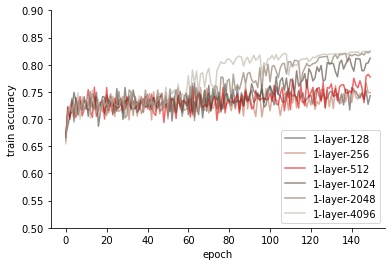

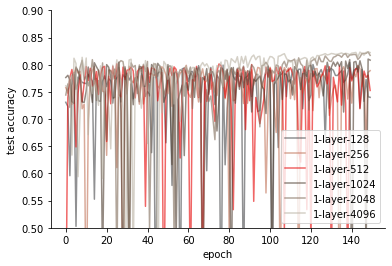

In [14]:
plot_accuracies(hist1, colors=['#464749' , '#c07156' ,'#e60000', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.5, upper_ylim=.9)

In [15]:
# lower the number of epochs
epochs = 150

histories = []

name="1-layer-128"
print(name)
model001 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model001.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model001.fit(x_train, y_train, batch_size=batch_size,
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))


name="1-layer-256"
print(name)
model002 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model002.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model002.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-512"
print(name)
model003 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model003.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model003.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-1024"
print(name)
model004 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model004.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model004.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-2048"
print(name)
model005 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model005.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model005.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-4096"
print(name)
model006 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model006.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model006.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))
hist1_2 = histories

1-layer-128
Epoch 1/150
163/163 - 1s - loss: 81.7165 - accuracy: 0.6485 - val_loss: 23.6218 - val_accuracy: 0.7265
Epoch 2/150
163/163 - 1s - loss: 11.9098 - accuracy: 0.7501 - val_loss: 5.8034 - val_accuracy: 0.6283
Epoch 3/150
163/163 - 1s - loss: 19.8829 - accuracy: 0.6723 - val_loss: 16.3043 - val_accuracy: 0.7533
Epoch 4/150
163/163 - 1s - loss: 10.0574 - accuracy: 0.7436 - val_loss: 4.5202 - val_accuracy: 0.7784
Epoch 5/150
163/163 - 1s - loss: 7.1041 - accuracy: 0.7466 - val_loss: 3.7810 - val_accuracy: 0.7955
Epoch 6/150
163/163 - 1s - loss: 8.3192 - accuracy: 0.7315 - val_loss: 2.6991 - val_accuracy: 0.8006
Epoch 7/150
163/163 - 1s - loss: 8.2682 - accuracy: 0.7181 - val_loss: 6.0918 - val_accuracy: 0.7631
Epoch 8/150
163/163 - 1s - loss: 9.0489 - accuracy: 0.7100 - val_loss: 3.2573 - val_accuracy: 0.7737
Epoch 9/150
163/163 - 1s - loss: 5.4787 - accuracy: 0.7385 - val_loss: 2.6970 - val_accuracy: 0.8016
Epoch 10/150
163/163 - 1s - loss: 9.5434 - accuracy: 0.6913 - val_loss: 4

Epoch 82/150
163/163 - 1s - loss: 0.4127 - accuracy: 0.8152 - val_loss: 0.4132 - val_accuracy: 0.8152
Epoch 83/150
163/163 - 1s - loss: 0.4109 - accuracy: 0.8172 - val_loss: 0.4089 - val_accuracy: 0.8175
Epoch 84/150
163/163 - 1s - loss: 0.4080 - accuracy: 0.8174 - val_loss: 0.4060 - val_accuracy: 0.8185
Epoch 85/150
163/163 - 1s - loss: 0.4142 - accuracy: 0.8155 - val_loss: 0.4239 - val_accuracy: 0.8107
Epoch 86/150
163/163 - 1s - loss: 0.4107 - accuracy: 0.8172 - val_loss: 0.4063 - val_accuracy: 0.8181
Epoch 87/150
163/163 - 1s - loss: 0.4130 - accuracy: 0.8161 - val_loss: 0.4208 - val_accuracy: 0.8116
Epoch 88/150
163/163 - 1s - loss: 0.4069 - accuracy: 0.8180 - val_loss: 0.4198 - val_accuracy: 0.8138
Epoch 89/150
163/163 - 1s - loss: 0.4101 - accuracy: 0.8172 - val_loss: 0.4272 - val_accuracy: 0.8096
Epoch 90/150
163/163 - 1s - loss: 0.4111 - accuracy: 0.8167 - val_loss: 0.4060 - val_accuracy: 0.8187
Epoch 91/150
163/163 - 1s - loss: 0.4091 - accuracy: 0.8178 - val_loss: 0.4102 - v

Epoch 12/150
163/163 - 1s - loss: 5.5177 - accuracy: 0.7255 - val_loss: 3.9662 - val_accuracy: 0.6543
Epoch 13/150
163/163 - 1s - loss: 4.3379 - accuracy: 0.7499 - val_loss: 3.3833 - val_accuracy: 0.5712
Epoch 14/150
163/163 - 1s - loss: 6.5835 - accuracy: 0.7019 - val_loss: 12.1005 - val_accuracy: 0.7238
Epoch 15/150
163/163 - 1s - loss: 5.8292 - accuracy: 0.7258 - val_loss: 2.0338 - val_accuracy: 0.8065
Epoch 16/150
163/163 - 1s - loss: 2.8494 - accuracy: 0.7509 - val_loss: 2.7591 - val_accuracy: 0.7724
Epoch 17/150
163/163 - 1s - loss: 4.2052 - accuracy: 0.7488 - val_loss: 3.9702 - val_accuracy: 0.3962
Epoch 18/150
163/163 - 1s - loss: 4.4736 - accuracy: 0.6913 - val_loss: 4.9874 - val_accuracy: 0.7499
Epoch 19/150
163/163 - 1s - loss: 2.7578 - accuracy: 0.7352 - val_loss: 9.4051 - val_accuracy: 0.2921
Epoch 20/150
163/163 - 1s - loss: 3.0456 - accuracy: 0.7258 - val_loss: 1.2992 - val_accuracy: 0.8022
Epoch 21/150
163/163 - 1s - loss: 2.8175 - accuracy: 0.7201 - val_loss: 3.5934 - 

Epoch 93/150
163/163 - 1s - loss: 0.4129 - accuracy: 0.8177 - val_loss: 0.4170 - val_accuracy: 0.8156
Epoch 94/150
163/163 - 1s - loss: 0.4097 - accuracy: 0.8187 - val_loss: 0.4280 - val_accuracy: 0.8115
Epoch 95/150
163/163 - 1s - loss: 0.4052 - accuracy: 0.8210 - val_loss: 0.4061 - val_accuracy: 0.8212
Epoch 96/150
163/163 - 1s - loss: 0.4086 - accuracy: 0.8207 - val_loss: 0.4149 - val_accuracy: 0.8166
Epoch 97/150
163/163 - 1s - loss: 0.4057 - accuracy: 0.8200 - val_loss: 0.4258 - val_accuracy: 0.8118
Epoch 98/150
163/163 - 1s - loss: 0.4061 - accuracy: 0.8204 - val_loss: 0.4081 - val_accuracy: 0.8192
Epoch 99/150
163/163 - 1s - loss: 0.4037 - accuracy: 0.8207 - val_loss: 0.4076 - val_accuracy: 0.8186
Epoch 100/150
163/163 - 1s - loss: 0.4096 - accuracy: 0.8189 - val_loss: 0.4028 - val_accuracy: 0.8215
Epoch 101/150
163/163 - 1s - loss: 0.4044 - accuracy: 0.8204 - val_loss: 0.4588 - val_accuracy: 0.8073
Epoch 102/150
163/163 - 1s - loss: 0.4121 - accuracy: 0.8182 - val_loss: 0.4272 

Epoch 23/150
163/163 - 1s - loss: 0.4628 - accuracy: 0.7953 - val_loss: 0.4797 - val_accuracy: 0.7884
Epoch 24/150
163/163 - 1s - loss: 0.4974 - accuracy: 0.7845 - val_loss: 0.4525 - val_accuracy: 0.7970
Epoch 25/150
163/163 - 1s - loss: 0.4596 - accuracy: 0.7957 - val_loss: 0.5111 - val_accuracy: 0.7721
Epoch 26/150
163/163 - 1s - loss: 0.4375 - accuracy: 0.8038 - val_loss: 0.4595 - val_accuracy: 0.7954
Epoch 27/150
163/163 - 1s - loss: 0.4300 - accuracy: 0.8066 - val_loss: 0.4358 - val_accuracy: 0.8065
Epoch 28/150
163/163 - 1s - loss: 0.4400 - accuracy: 0.8042 - val_loss: 0.4324 - val_accuracy: 0.8076
Epoch 29/150
163/163 - 1s - loss: 0.4260 - accuracy: 0.8100 - val_loss: 0.4610 - val_accuracy: 0.7912
Epoch 30/150
163/163 - 1s - loss: 0.4251 - accuracy: 0.8098 - val_loss: 0.4196 - val_accuracy: 0.8126
Epoch 31/150
163/163 - 1s - loss: 0.5194 - accuracy: 0.7847 - val_loss: 0.4339 - val_accuracy: 0.8088
Epoch 32/150
163/163 - 1s - loss: 0.4166 - accuracy: 0.8151 - val_loss: 0.4246 - v

Epoch 104/150
163/163 - 1s - loss: 0.4009 - accuracy: 0.8241 - val_loss: 0.4194 - val_accuracy: 0.8212
Epoch 105/150
163/163 - 1s - loss: 0.4007 - accuracy: 0.8236 - val_loss: 0.4227 - val_accuracy: 0.8152
Epoch 106/150
163/163 - 1s - loss: 0.4066 - accuracy: 0.8230 - val_loss: 0.4181 - val_accuracy: 0.8209
Epoch 107/150
163/163 - 1s - loss: 0.4031 - accuracy: 0.8233 - val_loss: 0.4174 - val_accuracy: 0.8167
Epoch 108/150
163/163 - 1s - loss: 0.4025 - accuracy: 0.8240 - val_loss: 0.4207 - val_accuracy: 0.8187
Epoch 109/150
163/163 - 1s - loss: 0.4031 - accuracy: 0.8235 - val_loss: 0.4063 - val_accuracy: 0.8231
Epoch 110/150
163/163 - 1s - loss: 0.4002 - accuracy: 0.8245 - val_loss: 0.4023 - val_accuracy: 0.8230
Epoch 111/150
163/163 - 1s - loss: 0.3999 - accuracy: 0.8251 - val_loss: 0.4050 - val_accuracy: 0.8190
Epoch 112/150
163/163 - 1s - loss: 0.3995 - accuracy: 0.8242 - val_loss: 0.4066 - val_accuracy: 0.8233
Epoch 113/150
163/163 - 1s - loss: 0.4026 - accuracy: 0.8243 - val_loss: 

Epoch 34/150
163/163 - 2s - loss: 0.4611 - accuracy: 0.8029 - val_loss: 0.4405 - val_accuracy: 0.8074
Epoch 35/150
163/163 - 2s - loss: 0.4518 - accuracy: 0.8007 - val_loss: 0.4447 - val_accuracy: 0.8043
Epoch 36/150
163/163 - 2s - loss: 0.4465 - accuracy: 0.8011 - val_loss: 0.4345 - val_accuracy: 0.8077
Epoch 37/150
163/163 - 2s - loss: 0.4467 - accuracy: 0.8016 - val_loss: 0.4262 - val_accuracy: 0.8102
Epoch 38/150
163/163 - 2s - loss: 0.4706 - accuracy: 0.7920 - val_loss: 0.7065 - val_accuracy: 0.7512
Epoch 39/150
163/163 - 2s - loss: 0.5990 - accuracy: 0.7802 - val_loss: 0.4190 - val_accuracy: 0.8148
Epoch 40/150
163/163 - 2s - loss: 0.4332 - accuracy: 0.8073 - val_loss: 0.4236 - val_accuracy: 0.8123
Epoch 41/150
163/163 - 2s - loss: 0.4169 - accuracy: 0.8141 - val_loss: 0.4144 - val_accuracy: 0.8167
Epoch 42/150
163/163 - 2s - loss: 0.4160 - accuracy: 0.8152 - val_loss: 0.4181 - val_accuracy: 0.8177
Epoch 43/150
163/163 - 2s - loss: 0.4196 - accuracy: 0.8136 - val_loss: 0.4472 - v

Epoch 115/150
163/163 - 2s - loss: 0.4004 - accuracy: 0.8245 - val_loss: 0.4015 - val_accuracy: 0.8238
Epoch 116/150
163/163 - 2s - loss: 0.4025 - accuracy: 0.8240 - val_loss: 0.3982 - val_accuracy: 0.8253
Epoch 117/150
163/163 - 2s - loss: 0.3984 - accuracy: 0.8257 - val_loss: 0.4047 - val_accuracy: 0.8238
Epoch 118/150
163/163 - 2s - loss: 0.4009 - accuracy: 0.8247 - val_loss: 0.4076 - val_accuracy: 0.8207
Epoch 119/150
163/163 - 2s - loss: 0.4038 - accuracy: 0.8241 - val_loss: 0.4072 - val_accuracy: 0.8201
Epoch 120/150
163/163 - 2s - loss: 0.3949 - accuracy: 0.8274 - val_loss: 0.4054 - val_accuracy: 0.8219
Epoch 121/150
163/163 - 2s - loss: 0.4006 - accuracy: 0.8253 - val_loss: 0.4238 - val_accuracy: 0.8114
Epoch 122/150
163/163 - 2s - loss: 0.4009 - accuracy: 0.8252 - val_loss: 0.3995 - val_accuracy: 0.8252
Epoch 123/150
163/163 - 2s - loss: 0.3991 - accuracy: 0.8254 - val_loss: 0.4032 - val_accuracy: 0.8234
Epoch 124/150
163/163 - 2s - loss: 0.3939 - accuracy: 0.8274 - val_loss: 

Epoch 45/150
163/163 - 2s - loss: 0.4042 - accuracy: 0.8222 - val_loss: 0.4101 - val_accuracy: 0.8198
Epoch 46/150
163/163 - 2s - loss: 0.4066 - accuracy: 0.8220 - val_loss: 0.4054 - val_accuracy: 0.8228
Epoch 47/150
163/163 - 2s - loss: 0.4063 - accuracy: 0.8219 - val_loss: 0.4347 - val_accuracy: 0.8156
Epoch 48/150
163/163 - 2s - loss: 0.4062 - accuracy: 0.8209 - val_loss: 0.3995 - val_accuracy: 0.8245
Epoch 49/150
163/163 - 2s - loss: 0.4107 - accuracy: 0.8201 - val_loss: 0.4001 - val_accuracy: 0.8242
Epoch 50/150
163/163 - 2s - loss: 0.4025 - accuracy: 0.8229 - val_loss: 0.4017 - val_accuracy: 0.8236
Epoch 51/150
163/163 - 2s - loss: 0.4009 - accuracy: 0.8237 - val_loss: 0.4104 - val_accuracy: 0.8244
Epoch 52/150
163/163 - 2s - loss: 0.4028 - accuracy: 0.8232 - val_loss: 0.3998 - val_accuracy: 0.8243
Epoch 53/150
163/163 - 2s - loss: 0.4092 - accuracy: 0.8204 - val_loss: 0.3974 - val_accuracy: 0.8257
Epoch 54/150
163/163 - 2s - loss: 0.4054 - accuracy: 0.8217 - val_loss: 0.3966 - v

163/163 - 2s - loss: 0.4025 - accuracy: 0.8238 - val_loss: 0.4030 - val_accuracy: 0.8236
Epoch 126/150
163/163 - 2s - loss: 0.4000 - accuracy: 0.8255 - val_loss: 0.4474 - val_accuracy: 0.8124
Epoch 127/150
163/163 - 2s - loss: 0.3987 - accuracy: 0.8254 - val_loss: 0.4066 - val_accuracy: 0.8187
Epoch 128/150
163/163 - 2s - loss: 0.3989 - accuracy: 0.8246 - val_loss: 0.3987 - val_accuracy: 0.8246
Epoch 129/150
163/163 - 2s - loss: 0.3989 - accuracy: 0.8258 - val_loss: 0.4233 - val_accuracy: 0.8191
Epoch 130/150
163/163 - 2s - loss: 0.3974 - accuracy: 0.8261 - val_loss: 0.4033 - val_accuracy: 0.8240
Epoch 131/150
163/163 - 2s - loss: 0.4040 - accuracy: 0.8240 - val_loss: 0.4013 - val_accuracy: 0.8230
Epoch 132/150
163/163 - 2s - loss: 0.3996 - accuracy: 0.8243 - val_loss: 0.4148 - val_accuracy: 0.8198
Epoch 133/150
163/163 - 2s - loss: 0.3968 - accuracy: 0.8259 - val_loss: 0.4190 - val_accuracy: 0.8199
Epoch 134/150
163/163 - 2s - loss: 0.4002 - accuracy: 0.8250 - val_loss: 0.4046 - val_a

163/163 - 4s - loss: 0.8335 - accuracy: 0.5561 - val_loss: 0.6923 - val_accuracy: 0.7188
Epoch 56/150
163/163 - 4s - loss: 0.8109 - accuracy: 0.7047 - val_loss: 0.6684 - val_accuracy: 0.7189
Epoch 57/150
163/163 - 4s - loss: 0.6230 - accuracy: 0.7114 - val_loss: 0.5084 - val_accuracy: 0.7189
Epoch 58/150
163/163 - 4s - loss: 0.4607 - accuracy: 0.7145 - val_loss: 0.4421 - val_accuracy: 0.7190
Epoch 59/150
163/163 - 4s - loss: 0.4558 - accuracy: 0.7145 - val_loss: 0.4409 - val_accuracy: 0.7190
Epoch 60/150
163/163 - 4s - loss: 0.4451 - accuracy: 0.7310 - val_loss: 0.4582 - val_accuracy: 0.7958
Epoch 61/150
163/163 - 4s - loss: 0.4480 - accuracy: 0.8039 - val_loss: 0.4325 - val_accuracy: 0.8132
Epoch 62/150
163/163 - 4s - loss: 0.4358 - accuracy: 0.8109 - val_loss: 0.4307 - val_accuracy: 0.8142
Epoch 63/150
163/163 - 4s - loss: 0.4329 - accuracy: 0.8113 - val_loss: 0.4283 - val_accuracy: 0.8125
Epoch 64/150
163/163 - 4s - loss: 0.4298 - accuracy: 0.8130 - val_loss: 0.4500 - val_accuracy: 

163/163 - 4s - loss: 0.4182 - accuracy: 0.8112 - val_loss: 0.4200 - val_accuracy: 0.8095
Epoch 136/150
163/163 - 4s - loss: 0.4196 - accuracy: 0.8115 - val_loss: 0.4291 - val_accuracy: 0.8085
Epoch 137/150
163/163 - 4s - loss: 0.4172 - accuracy: 0.8119 - val_loss: 0.4187 - val_accuracy: 0.8099
Epoch 138/150
163/163 - 4s - loss: 0.4181 - accuracy: 0.8114 - val_loss: 0.4174 - val_accuracy: 0.8112
Epoch 139/150
163/163 - 4s - loss: 0.4186 - accuracy: 0.8114 - val_loss: 0.4190 - val_accuracy: 0.8104
Epoch 140/150
163/163 - 4s - loss: 0.4149 - accuracy: 0.8122 - val_loss: 0.4185 - val_accuracy: 0.8096
Epoch 141/150
163/163 - 4s - loss: 0.4163 - accuracy: 0.8118 - val_loss: 0.4335 - val_accuracy: 0.8076
Epoch 142/150
163/163 - 4s - loss: 0.4193 - accuracy: 0.8112 - val_loss: 0.4302 - val_accuracy: 0.8087
Epoch 143/150
163/163 - 4s - loss: 0.4183 - accuracy: 0.8113 - val_loss: 0.4192 - val_accuracy: 0.8103
Epoch 144/150
163/163 - 4s - loss: 0.4185 - accuracy: 0.8110 - val_loss: 0.4353 - val_a

In [16]:
acc_df(histories)
#acc_df(hist1_2)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128,0.41,82.08%,0.41,81.98%
1-layer-256,0.40,82.20%,0.40,82.43%
1-layer-512,0.41,82.20%,0.40,82.61%
1-layer-1024,0.40,82.46%,0.40,82.54%
1-layer-2048,0.41,82.04%,0.40,82.57%
1-layer-4096,0.40,82.17%,0.40,82.62%


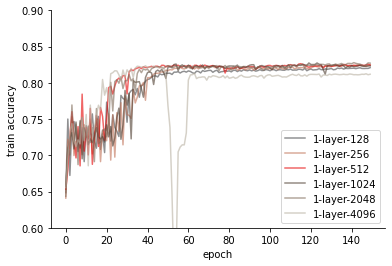

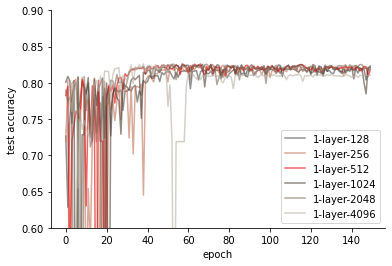

In [17]:
plot_accuracies(hist1_2, colors=['#464749' , '#c07156', '#e60000', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.6, upper_ylim=.9)

In [18]:
models = [model001, model002, model003, model004, model005, model006]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128,69.38%,62.58%
1-layer-256,69.03%,65.22%
1-layer-512,73.57%,54.38%
1-layer-1024,69.62%,63.56%
1-layer-2048,69.23%,66.24%
1-layer-4096,67.89%,61.52%


## Results from simple dense net

The simple dense net reaches a accuracy on out test dataset of nearly 72 percent. This sounds respectable for such a simple network. A closer look on our confusion matrix reveals that our network suffers from our imbalanced data and is not able to counter the imbalance and thus classifies nearly all patches as non-cancer.


At this point it is difficult to assess what exactly has to be improved, but we suspect the following issues persist:

1. The Neural Network does not learn enough from the features, most likely the size of the network is insufficient to learn the features. When increasing the number of layers and the size of the layers we will encounter additional challenges:
    - We could be overfitting our data, which we can mitigate by using dropbout layer
    - We could have a vanishing gradient, which can be mitigated by using normalisazion betweek the hidden layers 
2. The network minimizes the loss, since the data is imbalanced it will inherently favor negative classifications. To counter this multiple options are available
    - We could downsample the negative patches or upsample the positive patches , where the latter is preferred since no data is ignored this way.
    - We could apply balanced weights to increase the impact to the loss function for the positive patches. This should result in an equivalent result than the upsampling.

We will takle the two above mentioned issues after each other. Fist we try to increase the model size and tune the hyperparameters to fit the data better and learn the complexity of the input. Second we will apply class weights to tackle specifically the imbalanced data

## Normalization & dropout layers

In [19]:
# lower the number of epochs
epochs = 500

histories = []

name="1-layer-128-norm-dropout"
print(name)
model07 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model07.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model07.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="1-layer-4096-norm-dropout"
print(name)
model08 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model08.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model08.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))


name="2-layer-128-256-norm"
print(name)
model09 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model09.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model09.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="2-layer-128-256-dropout"
print(name)
model10 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model10.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model10.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))


name="2-layer-128-256-norm-dropout"
print(name)
model12 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model12.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model12.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="3-layer-512-256-128-norm-dropout"
print(name)
model13 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model13.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model13.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))
hist2 = histories

1-layer-128-norm-dropout
Epoch 1/500
163/163 - 1s - loss: 0.6049 - accuracy: 0.7868 - val_loss: 0.7807 - val_accuracy: 0.7750
Epoch 2/500
163/163 - 1s - loss: 0.4266 - accuracy: 0.8147 - val_loss: 0.3921 - val_accuracy: 0.8332
Epoch 3/500
163/163 - 1s - loss: 0.3943 - accuracy: 0.8299 - val_loss: 0.3697 - val_accuracy: 0.8416
Epoch 4/500
163/163 - 1s - loss: 0.3745 - accuracy: 0.8403 - val_loss: 0.3629 - val_accuracy: 0.8447
Epoch 5/500
163/163 - 1s - loss: 0.3622 - accuracy: 0.8466 - val_loss: 0.3553 - val_accuracy: 0.8482
Epoch 6/500
163/163 - 1s - loss: 0.3546 - accuracy: 0.8502 - val_loss: 0.3553 - val_accuracy: 0.8483
Epoch 7/500
163/163 - 1s - loss: 0.3482 - accuracy: 0.8532 - val_loss: 0.3532 - val_accuracy: 0.8497
Epoch 8/500
163/163 - 1s - loss: 0.3423 - accuracy: 0.8563 - val_loss: 0.3531 - val_accuracy: 0.8511
Epoch 9/500
163/163 - 1s - loss: 0.3376 - accuracy: 0.8593 - val_loss: 0.3571 - val_accuracy: 0.8499
Epoch 10/500
163/163 - 1s - loss: 0.3349 - accuracy: 0.8602 - val_

Epoch 2/500
163/163 - 1s - loss: 0.3499 - accuracy: 0.8495 - val_loss: 0.4051 - val_accuracy: 0.8396
Epoch 3/500
163/163 - 1s - loss: 0.3311 - accuracy: 0.8585 - val_loss: 0.3522 - val_accuracy: 0.8481
Epoch 4/500
163/163 - 1s - loss: 0.3164 - accuracy: 0.8658 - val_loss: 0.3545 - val_accuracy: 0.8479
Epoch 5/500
163/163 - 1s - loss: 0.3046 - accuracy: 0.8715 - val_loss: 0.3588 - val_accuracy: 0.8455
Epoch 6/500
163/163 - 1s - loss: 0.2887 - accuracy: 0.8800 - val_loss: 0.3825 - val_accuracy: 0.8291
Epoch 7/500
163/163 - 1s - loss: 0.2785 - accuracy: 0.8846 - val_loss: 0.3738 - val_accuracy: 0.8398
Epoch 8/500
163/163 - 1s - loss: 0.2610 - accuracy: 0.8935 - val_loss: 0.3961 - val_accuracy: 0.8338
Epoch 9/500
163/163 - 1s - loss: 0.2463 - accuracy: 0.8999 - val_loss: 0.4173 - val_accuracy: 0.8222
Epoch 10/500
163/163 - 1s - loss: 0.2279 - accuracy: 0.9090 - val_loss: 0.4337 - val_accuracy: 0.8201
Epoch 11/500
163/163 - 1s - loss: 0.2133 - accuracy: 0.9149 - val_loss: 0.4425 - val_accur

Epoch 17/500
163/163 - 1s - loss: 0.2837 - accuracy: 0.8843 - val_loss: 0.3552 - val_accuracy: 0.8509
Epoch 18/500
163/163 - 1s - loss: 0.2778 - accuracy: 0.8870 - val_loss: 0.3577 - val_accuracy: 0.8510
Epoch 19/500
163/163 - 1s - loss: 0.2735 - accuracy: 0.8890 - val_loss: 0.3628 - val_accuracy: 0.8466
Epoch 20/500
163/163 - 1s - loss: 0.2669 - accuracy: 0.8924 - val_loss: 0.3748 - val_accuracy: 0.8443
Epoch 21/500
163/163 - 1s - loss: 0.2622 - accuracy: 0.8941 - val_loss: 0.3738 - val_accuracy: 0.8493
Epoch 22/500
163/163 - 1s - loss: 0.2579 - accuracy: 0.8959 - val_loss: 0.3765 - val_accuracy: 0.8468
Epoch 23/500
163/163 - 1s - loss: 0.2510 - accuracy: 0.8996 - val_loss: 0.3788 - val_accuracy: 0.8459
Epoch 24/500
163/163 - 1s - loss: 0.2468 - accuracy: 0.9013 - val_loss: 0.3777 - val_accuracy: 0.8470
Epoch 25/500
163/163 - 1s - loss: 0.2411 - accuracy: 0.9038 - val_loss: 0.3878 - val_accuracy: 0.8446
Epoch 26/500
163/163 - 1s - loss: 0.2385 - accuracy: 0.9045 - val_loss: 0.3902 - v

In [20]:
acc_df(hist2)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,0.33,86.02%,0.35,85.18%
1-layer-4096-norm-dropout,0.33,86.19%,0.35,85.31%
2-layer-128-256-norm,0.33,85.85%,0.35,84.81%
2-layer-128-256-dropout,18.60,70.07%,0.62,71.90%
2-layer-128-256-norm-dropout,0.32,86.80%,0.35,85.18%
3-layer-512-256-128-norm-dropout,0.31,86.94%,0.34,85.35%


In [21]:
models = [model07, model08, model09, model10, model12, model13]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128-norm-dropout,74.96%,70.62%
1-layer-4096-norm-dropout,75.76%,69.06%
2-layer-128-256-norm,73.78%,70.55%
2-layer-128-256-dropout,0.00%,0.00%
2-layer-128-256-norm-dropout,74.14%,72.11%
3-layer-512-256-128-norm-dropout,74.91%,71.28%


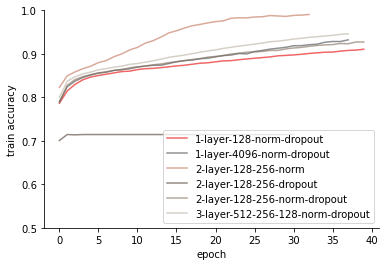

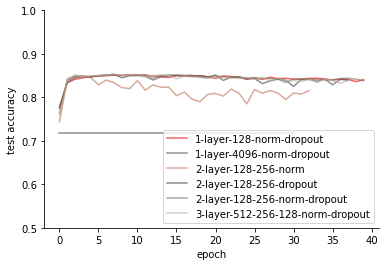

In [22]:
plot_accuracies(hist2, colors=['#e60000', '#464749' , '#c07156', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.5, upper_ylim=1)

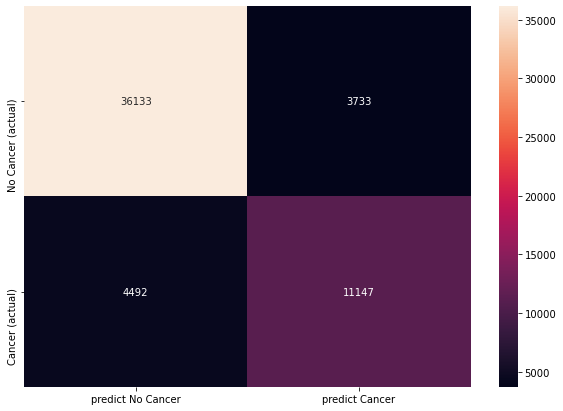

In [23]:
# plot confuction matrix
plt=conf_matrix(model13, x_test, y_test)
plt.show()

## Learnings
- In the above chart we first of all see that just increasing the number of layers and the number of hidden nodes per layer did not improve the performance. On the contrary we can recognize that in the 3rd network the loss is increasing significantly and and the fourth and fifth layer the loss cannot be displayed. This evidence suggests an exploding/vanishing gradient.
- None of the models are able to reach higher performance for our imbalanced dataset and account for the cancer positive cells
With the different model sizes, learning rates, normalization and dropout layers most issues should have be tackled, so lets run tha above models again with balanced weights, that account for the relative number of positive/negative patches

In [24]:
# lower the number of epochs
epochs = 500

histories = []

name="1-layer-128-norm-dropout"
print(name)
model14 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model14.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model14.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))


name="2-layer-128-256-norm-dropout"
print(name)
model15 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model15.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model15.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))

name="3-layer-512-256-128-norm-dropout"
print(name)
model16 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model16.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model16.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))
hist3 = histories

1-layer-128-norm-dropout
Epoch 1/500
163/163 - 1s - loss: 1.1674 - accuracy: 0.7564 - val_loss: 0.9184 - val_accuracy: 0.7755
Epoch 2/500
163/163 - 1s - loss: 0.9320 - accuracy: 0.7868 - val_loss: 0.4154 - val_accuracy: 0.8145
Epoch 3/500
163/163 - 1s - loss: 0.9001 - accuracy: 0.7970 - val_loss: 0.4665 - val_accuracy: 0.7949
Epoch 4/500
163/163 - 1s - loss: 0.8772 - accuracy: 0.8032 - val_loss: 0.4524 - val_accuracy: 0.7949
Epoch 5/500
163/163 - 1s - loss: 0.8599 - accuracy: 0.8072 - val_loss: 0.4282 - val_accuracy: 0.8045
Epoch 6/500
163/163 - 1s - loss: 0.8472 - accuracy: 0.8093 - val_loss: 0.4516 - val_accuracy: 0.7955
Epoch 7/500
163/163 - 1s - loss: 0.8388 - accuracy: 0.8120 - val_loss: 0.4655 - val_accuracy: 0.7916
Epoch 8/500
163/163 - 1s - loss: 0.8312 - accuracy: 0.8150 - val_loss: 0.4058 - val_accuracy: 0.8207
Epoch 9/500
163/163 - 1s - loss: 0.8231 - accuracy: 0.8158 - val_loss: 0.4307 - val_accuracy: 0.8051
Epoch 10/500
163/163 - 1s - loss: 0.8159 - accuracy: 0.8186 - val_

Epoch 34/500
163/163 - 1s - loss: 0.5591 - accuracy: 0.8763 - val_loss: 0.4623 - val_accuracy: 0.8127
Epoch 35/500
163/163 - 1s - loss: 0.5470 - accuracy: 0.8792 - val_loss: 0.4664 - val_accuracy: 0.8085
Epoch 36/500
163/163 - 1s - loss: 0.5502 - accuracy: 0.8787 - val_loss: 0.4802 - val_accuracy: 0.7972
Epoch 37/500
163/163 - 1s - loss: 0.5433 - accuracy: 0.8804 - val_loss: 0.4961 - val_accuracy: 0.7924
Epoch 38/500

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
163/163 - 1s - loss: 0.5311 - accuracy: 0.8825 - val_loss: 0.5010 - val_accuracy: 0.8061
Epoch 39/500
163/163 - 1s - loss: 0.4685 - accuracy: 0.8970 - val_loss: 0.4732 - val_accuracy: 0.8241
Epoch 40/500
163/163 - 1s - loss: 0.4450 - accuracy: 0.9020 - val_loss: 0.4774 - val_accuracy: 0.8235
Epoch 41/500
163/163 - 1s - loss: 0.4324 - accuracy: 0.9039 - val_loss: 0.4899 - val_accuracy: 0.8278
Epoch 42/500
163/163 - 1s - loss: 0.4251 - accuracy: 0.9063 - val_loss: 0.5100 - val_accuracy: 0.8161
E

In [25]:
acc_df(hist3)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,0.78,82.65%,0.38,83.39%
2-layer-128-256-norm-dropout,0.65,85.94%,0.37,83.84%
3-layer-512-256-128-norm-dropout,0.85,81.46%,0.37,84.61%


In [26]:
models = [model14, model15, model16]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128-norm-dropout,68.18%,77.20%
2-layer-128-256-norm-dropout,69.68%,76.35%
3-layer-512-256-128-norm-dropout,73.56%,69.42%


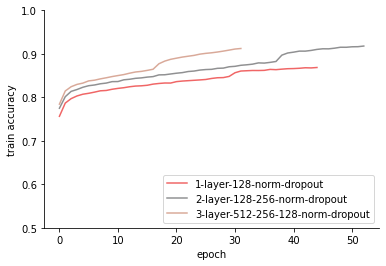

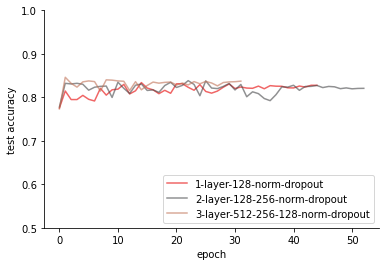

In [27]:
plot_accuracies(hist3, colors=['#e60000' , '#464749', '#c07156', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.5, upper_ylim=1)

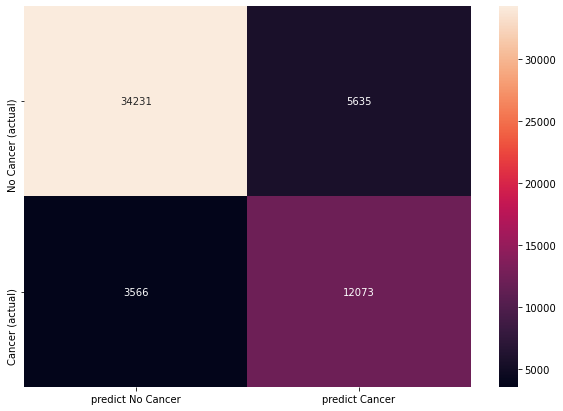

In [28]:
# plot confuction matrix
plt=conf_matrix(model14, x_test, y_test)
plt.show()

## Learnings
- The confusion matrix starts to look better, malicious cells are now classified much less as non-malicious than before
- In the graph above we see that the validation accuracy and loss is decreasing/increasing towards the end
- Train accuracy is now much closer to the validation accuracy (at least for the best epoch) over time they still diverge

Since the training and validatio accuracy are close we can reduce the dropout rate, but at the same time we will add an imageDataGenerator to hopefully increase generalizability of our model.On top we define a learning rate schedule that reduces when a plateau is reached and change all optimizations to from stochastig gradient descent to the adam optimizer.

Since the smaller networks needed more epochs to show improvements we remove the early stopping criterion for those and increase the patience for the rest, to make sure not to stop too early

In [29]:
#Image Data Augmentation

train_generator = ImageDataGenerator(horizontal_flip=True,
                                     vertical_flip=True)

test_generator = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True)

val_generator = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True)

train_generator.fit(x_train)
test_generator.fit(x_test)
val_generator.fit(x_val)

In [30]:
histories = []

name="1-layer-128-norm-dropout"
print(name)
model17 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model17.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model17.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))

name="2-layer-128-256-norm-dropout"
print(name)
model18 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model18.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model18.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))

name="3-layer-512-256-128-norm-dropout"
print(name)
model19 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model19.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model19.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))
hist4 = histories

1-layer-128-norm-dropout
Epoch 1/500
5204/5204 [==============================] - 15s 3ms/step - loss: 0.9428 - accuracy: 0.7812 - val_loss: 0.4430 - val_accuracy: 0.7973
Epoch 2/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.9144 - accuracy: 0.7880 - val_loss: 0.4168 - val_accuracy: 0.8092
Epoch 3/500
5204/5204 [==============================] - 15s 3ms/step - loss: 0.9088 - accuracy: 0.7908 - val_loss: 0.4606 - val_accuracy: 0.7891
Epoch 4/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8973 - accuracy: 0.7951 - val_loss: 0.4726 - val_accuracy: 0.7723
Epoch 5/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8906 - accuracy: 0.7975 - val_loss: 0.4264 - val_accuracy: 0.8011
Epoch 6/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8859 - accuracy: 0.7985 - val_loss: 0.3945 - val_accuracy: 0.8213
Epoch 7/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8812 - accuracy: 0.

5204/5204 [==============================] - 16s 3ms/step - loss: 0.8503 - accuracy: 0.8146 - val_loss: 0.3916 - val_accuracy: 0.8373
Epoch 16/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.8482 - accuracy: 0.8148 - val_loss: 0.3688 - val_accuracy: 0.8370
Epoch 17/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.8433 - accuracy: 0.8147 - val_loss: 0.4352 - val_accuracy: 0.8110
Epoch 18/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.8432 - accuracy: 0.8150 - val_loss: 0.4165 - val_accuracy: 0.8134
Epoch 19/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.8419 - accuracy: 0.8168 - val_loss: 0.4448 - val_accuracy: 0.8119
Epoch 20/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.8398 - accuracy: 0.8163 - val_loss: 0.3516 - val_accuracy: 0.8511
Epoch 21/500
5204/5204 [==============================] - 16s 3ms/step - loss: 0.8378 - accuracy: 0.8172 - val_loss: 0.4133 - val_a

Epoch 00069: early stopping
3-layer-512-256-128-norm-dropout
Epoch 1/500
5204/5204 [==============================] - 20s 4ms/step - loss: 0.9366 - accuracy: 0.7914 - val_loss: 0.4932 - val_accuracy: 0.7997
Epoch 2/500
5204/5204 [==============================] - 20s 4ms/step - loss: 0.8978 - accuracy: 0.8003 - val_loss: 0.4360 - val_accuracy: 0.8100
Epoch 3/500
5204/5204 [==============================] - 20s 4ms/step - loss: 0.8758 - accuracy: 0.8075 - val_loss: 0.4143 - val_accuracy: 0.8202
Epoch 4/500
5204/5204 [==============================] - 20s 4ms/step - loss: 0.8614 - accuracy: 0.8089 - val_loss: 0.4115 - val_accuracy: 0.8174
Epoch 5/500
5204/5204 [==============================] - 20s 4ms/step - loss: 0.8618 - accuracy: 0.8081 - val_loss: 0.3847 - val_accuracy: 0.8369
Epoch 6/500
5204/5204 [==============================] - 20s 4ms/step - loss: 0.8483 - accuracy: 0.8122 - val_loss: 0.3849 - val_accuracy: 0.8312
Epoch 7/500
5204/5204 [==============================] - 20s 4m

In [31]:
acc_df(hist4)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,0.88,80.18%,0.37,83.89%
2-layer-128-256-norm-dropout,0.82,82.10%,0.38,85.55%
3-layer-512-256-128-norm-dropout,0.84,81.37%,0.36,84.92%


In [32]:
models = [model17, model18, model19]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128-norm-dropout,69.20%,76.04%
2-layer-128-256-norm-dropout,74.46%,73.28%
3-layer-512-256-128-norm-dropout,72.13%,75.50%


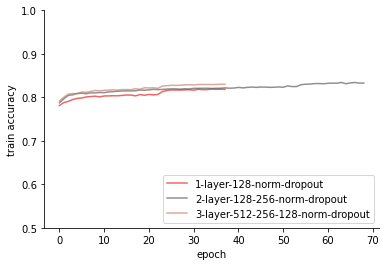

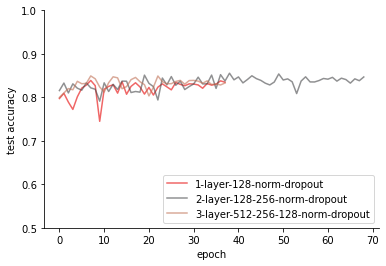

In [33]:
plot_accuracies(hist4, colors=['#e60000', '#464749', '#c07156', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.5, upper_ylim=1)

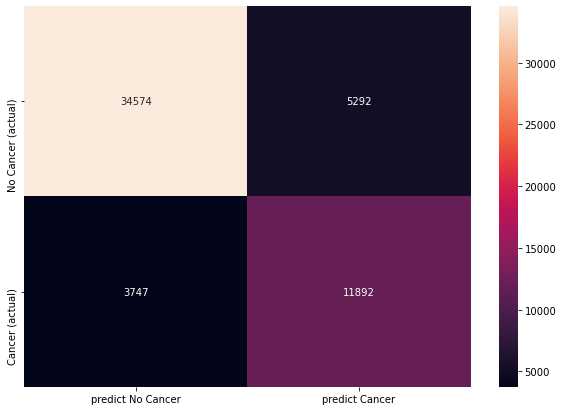

In [34]:
# plot confuction matrix
plt=conf_matrix(model17, x_test, y_test)
plt.show()

In [35]:
histories = []
name="1-layer-128-norm-dropout-lower"
print(name)
model20 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model20.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model20.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr],
                             class_weight=class_weight))
hist5 = histories

1-layer-128-norm-dropout-lower
Epoch 1/500
5204/5204 [==============================] - 15s 3ms/step - loss: 0.9255 - accuracy: 0.7864 - val_loss: 0.4726 - val_accuracy: 0.7851
Epoch 2/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8852 - accuracy: 0.7983 - val_loss: 0.4224 - val_accuracy: 0.8102
Epoch 3/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8723 - accuracy: 0.8023 - val_loss: 0.3996 - val_accuracy: 0.8266
Epoch 4/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8624 - accuracy: 0.8042 - val_loss: 0.3909 - val_accuracy: 0.8314
Epoch 5/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8550 - accuracy: 0.8070 - val_loss: 0.4087 - val_accuracy: 0.8137
Epoch 6/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8559 - accuracy: 0.8070 - val_loss: 0.3820 - val_accuracy: 0.8322
Epoch 7/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.8482 - accura

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7702 - accuracy: 0.8287 - val_loss: 0.3756 - val_accuracy: 0.8355
Epoch 55/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7707 - accuracy: 0.8296 - val_loss: 0.3802 - val_accuracy: 0.8318
Epoch 56/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7701 - accuracy: 0.8288 - val_loss: 0.3781 - val_accuracy: 0.8347
Epoch 57/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7727 - accuracy: 0.8283 - val_loss: 0.3804 - val_accuracy: 0.8322
Epoch 58/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7699 - accuracy: 0.8296 - val_loss: 0.3738 - val_accuracy: 0.8361
Epoch 59/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7701 - accuracy: 0.8272 - val_loss: 0.3730 - val_accuracy: 0.8363
Epoch 60/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7710 - accuracy: 0.8285 - val_loss: 0.3795 - val_a

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7667 - accuracy: 0.8301 - val_loss: 0.3785 - val_accuracy: 0.8337
Epoch 110/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7668 - accuracy: 0.8297 - val_loss: 0.3718 - val_accuracy: 0.8377
Epoch 111/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7678 - accuracy: 0.8301 - val_loss: 0.3762 - val_accuracy: 0.8339
Epoch 112/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7687 - accuracy: 0.8295 - val_loss: 0.3764 - val_accuracy: 0.8349
Epoch 113/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7660 - accuracy: 0.8305 - val_loss: 0.3848 - val_accuracy: 0.8306
Epoch 114/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7685 - accuracy: 0.8295 - val_loss: 0.3800 - val_accuracy: 0.8326
Epoch 115/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7660 - accuracy: 0.8301 - val_loss: 0.3760 -

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7635 - accuracy: 0.8309 - val_loss: 0.3740 - val_accuracy: 0.8355
Epoch 165/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7642 - accuracy: 0.8307 - val_loss: 0.3717 - val_accuracy: 0.8376
Epoch 166/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7653 - accuracy: 0.8294 - val_loss: 0.3802 - val_accuracy: 0.8335
Epoch 167/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7646 - accuracy: 0.8302 - val_loss: 0.3718 - val_accuracy: 0.8378
Epoch 168/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7645 - accuracy: 0.8305 - val_loss: 0.3777 - val_accuracy: 0.8338
Epoch 169/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7639 - accuracy: 0.8294 - val_loss: 0.3789 - val_accuracy: 0.8328
Epoch 170/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7646 - accuracy: 0.8296 - val_loss: 0.3723 -

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7608 - accuracy: 0.8317 - val_loss: 0.3735 - val_accuracy: 0.8356
Epoch 220/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7602 - accuracy: 0.8315 - val_loss: 0.3721 - val_accuracy: 0.8376
Epoch 221/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7612 - accuracy: 0.8309 - val_loss: 0.3773 - val_accuracy: 0.8341
Epoch 222/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7621 - accuracy: 0.8305 - val_loss: 0.3746 - val_accuracy: 0.8361
Epoch 223/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7606 - accuracy: 0.8311 - val_loss: 0.3749 - val_accuracy: 0.8360
Epoch 224/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7608 - accuracy: 0.8314 - val_loss: 0.3736 - val_accuracy: 0.8366
Epoch 225/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7634 - accuracy: 0.8309 - val_loss: 0.3737 -

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7583 - accuracy: 0.8326 - val_loss: 0.3723 - val_accuracy: 0.8368
Epoch 275/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7607 - accuracy: 0.8312 - val_loss: 0.3745 - val_accuracy: 0.8360
Epoch 276/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7571 - accuracy: 0.8319 - val_loss: 0.3717 - val_accuracy: 0.8375
Epoch 277/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7573 - accuracy: 0.8316 - val_loss: 0.3744 - val_accuracy: 0.8351
Epoch 278/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7595 - accuracy: 0.8311 - val_loss: 0.3722 - val_accuracy: 0.8374
Epoch 279/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7576 - accuracy: 0.8326 - val_loss: 0.3734 - val_accuracy: 0.8360
Epoch 280/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7580 - accuracy: 0.8325 - val_loss: 0.3730 -

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7547 - accuracy: 0.8333 - val_loss: 0.3706 - val_accuracy: 0.8384
Epoch 330/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7556 - accuracy: 0.8329 - val_loss: 0.3709 - val_accuracy: 0.8379
Epoch 331/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7584 - accuracy: 0.8314 - val_loss: 0.3752 - val_accuracy: 0.8368
Epoch 332/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7568 - accuracy: 0.8323 - val_loss: 0.3762 - val_accuracy: 0.8356
Epoch 333/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7565 - accuracy: 0.8323 - val_loss: 0.3715 - val_accuracy: 0.8385
Epoch 334/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7551 - accuracy: 0.8329 - val_loss: 0.3743 - val_accuracy: 0.8369
Epoch 335/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7576 - accuracy: 0.8329 - val_loss: 0.3747 -

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7542 - accuracy: 0.8326 - val_loss: 0.3642 - val_accuracy: 0.8415
Epoch 385/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7570 - accuracy: 0.8328 - val_loss: 0.3751 - val_accuracy: 0.8365
Epoch 386/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7561 - accuracy: 0.8331 - val_loss: 0.3723 - val_accuracy: 0.8378
Epoch 387/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7556 - accuracy: 0.8328 - val_loss: 0.3711 - val_accuracy: 0.8377
Epoch 388/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7562 - accuracy: 0.8317 - val_loss: 0.3676 - val_accuracy: 0.8389
Epoch 389/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7538 - accuracy: 0.8329 - val_loss: 0.3731 - val_accuracy: 0.8377
Epoch 390/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7548 - accuracy: 0.8327 - val_loss: 0.3718 -

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7530 - accuracy: 0.8331 - val_loss: 0.3774 - val_accuracy: 0.8356
Epoch 440/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7511 - accuracy: 0.8336 - val_loss: 0.3690 - val_accuracy: 0.8389
Epoch 441/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7487 - accuracy: 0.8344 - val_loss: 0.3757 - val_accuracy: 0.8355
Epoch 442/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7536 - accuracy: 0.8337 - val_loss: 0.3738 - val_accuracy: 0.8363
Epoch 443/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7546 - accuracy: 0.8341 - val_loss: 0.3734 - val_accuracy: 0.8363
Epoch 444/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7539 - accuracy: 0.8340 - val_loss: 0.3757 - val_accuracy: 0.8361
Epoch 445/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7512 - accuracy: 0.8331 - val_loss: 0.3729 -

5204/5204 [==============================] - 14s 3ms/step - loss: 0.7491 - accuracy: 0.8337 - val_loss: 0.3740 - val_accuracy: 0.8374
Epoch 495/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7499 - accuracy: 0.8334 - val_loss: 0.3720 - val_accuracy: 0.8384
Epoch 496/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7479 - accuracy: 0.8345 - val_loss: 0.3728 - val_accuracy: 0.8367
Epoch 497/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7491 - accuracy: 0.8339 - val_loss: 0.3731 - val_accuracy: 0.8373
Epoch 498/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7485 - accuracy: 0.8343 - val_loss: 0.3720 - val_accuracy: 0.8366
Epoch 499/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7495 - accuracy: 0.8342 - val_loss: 0.3727 - val_accuracy: 0.8373
Epoch 500/500
5204/5204 [==============================] - 14s 3ms/step - loss: 0.7472 - accuracy: 0.8360 - val_loss: 0.3673 -

In [36]:
acc_df(hist5)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout-lower,0.83,81.34%,0.36,84.54%


In [37]:
models = [model20]
prec_rec_df(models)

,precision (cancer positive),recall (cancer positive)
model,,
1-layer-128-norm-dropout-lower,68.01%,81.58%


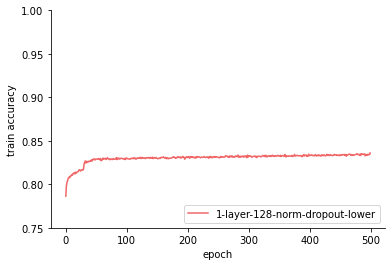

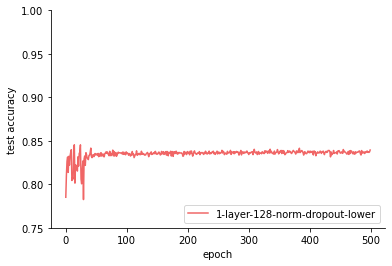

In [38]:
plot_accuracies(hist5, colors=['#e60000', '#464749', '#c07156', '#4d3c2f', '#806b59', '#b9b2a3'], lower_ylim=.75, upper_ylim=1)

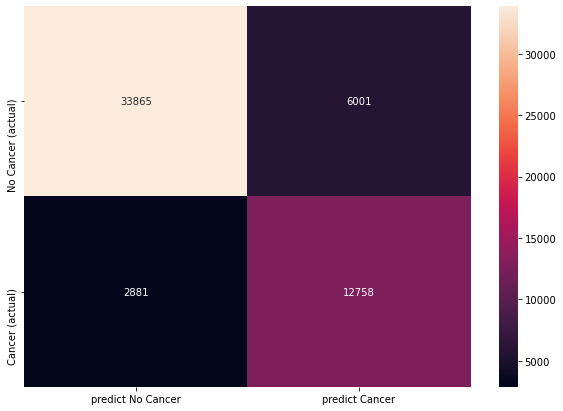

In [39]:
# plot confuction matrix
plt=conf_matrix(model20, x_test, y_test)
plt.show()

# Results

The final model does not seem to be far superior to previous ones if we observe the accuracy and the loss. It has one of the best performances if we measure validation loss and accuracy, but the first model with the learning rate 0.01 reached a similar performance according to those measures.
Since we are building a model for medical diagnosis, accuracy and loss are not neccessarily the most important measures (even though it makes sense to optimize them). including the confusion matrix in our model evaluation shows that we are constantly improving on predicting malicious cells and also minimize the classification of malicious cells as harmless, a missclassification, which could have severe implications for the patient.

Increasing the size of the model to a certain size, adding dropout and normalization layers, countering the imbalance of the data with balanced weights as well as applying a learning rate schedule improved the result significantly.

